In [1]:
import yt
import numpy as np
from matplotlib import pylab
from math import pi
import unyt
import pickle

/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
from yt.funcs import mylog

# only critical log messages are printed
mylog.setLevel(50)

# the default log level is 20, which shows warnings and info messages
# mylog.setLevel(20)

In [3]:
ts = yt.load('~jw254/data/SG64-2020/DD????/output_????')

# BH particle filter

In [4]:
@yt.particle_filter('p3_bh', ['creation_time', 'particle_mass', 'particle_type'])
def p3_bh(pfilter, data):
    return (data['particle_type'] == 1) & (data['creation_time'] > 0) & \
        (data['particle_mass'].in_units('Msun') > 1e-3)

# Find BH rate for each ds in ts
**Sometimes `unyt` just fails, gotta find alternatives.**
On Phoenix notebook, `unyt` does NOT work.

In [5]:
unyt.gravitational_constant

unyt_quantity(6.67408e-11, 'm**3/(kg*s**2)')

In [6]:
# convert unyt.gravitational_constant in unyt to yt units
from yt.units import kg, m, s
G = unyt.gravitational_constant.v * m**3/(kg*s**2)
G

6.67408e-11 m**3/(kg*s**2)

In [7]:
# when using yt.units instead of unyt
from yt.units import kg, m, s
def bondi_hoyle_rate(rho, cs, vrel, mbh, boost=1):
    vmag = ((vrel**2).sum())**0.5
    G = unyt.gravitational_constant.v * m**3/(kg*s**2)
    return boost * pi * rho * G**2 * mbh**2 / max(vmag, cs)**3

def bondi_radius(cs, mbh):
    G = unyt.gravitational_constant.v * m**3/(kg*s**2)
    return 2 * G * mbh / cs**2

# when using unyt
def bondi_hoyle_rate(rho, cs, vrel, mbh, boost=1):
    vmag = ((vrel**2).sum())**0.5
    return boost * pi * rho * unyt.gravitational_constant**2 * mbh**2 / max(vmag, cs)**3

def bondi_radius(cs, mbh):
    return 2 * unyt.gravitational_constant * mbh / cs**2

## To avoid `YTFieldNotFound: Could not find field '('gas', 'mass')' in output_0033.`
In older yt versions, `('gas', 'mass')` is actually `('gas', 'cell_mass')`!!!

`ds.r['gas', 'cell_mass'] == ds.r['gas', 'mass']`

In [8]:
# create dicts to store the BH rate and Bondi radius of each BH in each ds of the ts
ts_bh_rate = {}
ts_bondi_r = {}
for j in range(len(ts)):
    ds = ts[j] # MUST save to another variable for the particle filter to work
    ds.add_particle_filter('p3_bh')
    ad = ds.all_data() # using ts[j] do NOT work because the particle filter isn't saved
    bh_id = ad['p3_bh', 'particle_index']
    
    # dicts to store the BH rate and Bondi radius of each BH in the current ds
    ds_bh_rate = {}
    ds_bondi_r = {}

    for i in range(len(bh_id)): # loop over each BH found in ds
        # calculate BH rate for each BH
        pos = ad['p3_bh', 'particle_position'][i]
        mass = ad['p3_bh', 'particle_mass'][i]
        vbh = ad['p3_bh', 'particle_velocity'][i]
        # find quantities at the cell
        rho, cs, vx, vy, vz, dx = ds.find_field_values_at_point(['density', 'sound_speed', 'velocity_x', 'velocity_y', 'velocity_z', 'dx'], pos)
        vrel = ds.arr([vx-vbh[0], vy-vbh[1], vz-vbh[2]]) # find relative velocity
        # the initial values are in a list, but the resolved values are NOT!!!
        mbh_dt0 = bondi_hoyle_rate(rho, cs, vrel, mass)[0].to('Msun/yr') # initial BH rate
        #rb0 = bondi_radius(cs, mass)[0].to('pc') # initial Bondi radius
        rb0 = bondi_radius(cs, mass)[0].to('pc') * 10000 # JUST FOR TESTING!!! # initial Bondi radius
        dx0 = dx[0].to('pc') # initial cell width

        # Only iterate if the Bondi radius is larger than the cell width, that is, the Bondi sphere is resolved
        tolerance = 0.05  # Stop iterating when the r_Bondi changes less than this percentage
        change = 1e20  # Arbitrary large number to go into the first loop
        rb_last = rb0.copy() # rb0 is a list of 1 item
        rb = rb0.copy() # rb0 is a list of 1 item
        mbh_dt = mbh_dt0.copy() # remember initial BH rate in case the Bondi sphere is NOT resolved
        if dx0 < rb0:
            while change > tolerance:
                try:
                    sp = ds.sphere(pos, rb) # make a sphere with the initial Bondi radius
                # when YTSphereTooSmall error arises, break out of the while loop, use the last results, and continue to the next BH
                except:
                    break
                # find updated quantities from averaging within the Bondi radius
                rhobar, csbar, vxbar, vybar, vzbar = \
                    sp.quantities.weighted_average_quantity(['density', 'sound_speed', 'velocity_x', 'velocity_y', 'velocity_z'],
                                                            weight=('gas', 'cell_mass'))
                vrelbar = ds.arr([vxbar-vbh[0], vybar-vbh[1], vzbar-vbh[2]])
                # update BH rate and Bondi radius with new quantities
                mbh_dt = bondi_hoyle_rate(rhobar, csbar, vrelbar, mass)
                rb = bondi_radius(csbar, mass)
                change = abs(rb - rb_last) / rb_last # find the change % between new and old Bondi radius
                rb_last = rb.copy() # to remember the prior updated Bondi radius for the next loop
            print(i, 'Resolved Bondi-Hoyle rate = %s, resolved Bondi radius = %s' % (mbh_dt.to('Msun/yr'), rb_last.to('pc')))

        else:
            print(i, 'Bondi radius (%s) in cell is smaller than resolution element (%s), Bondi-Hoyle rate = %s' % (rb0.to('pc'), dx0.to('pc'), mbh_dt.to('Msun/yr')))

        # add results to dict with keys as BH indices
        ds_bondi_r[int(bh_id[i])] = rb_last.to('pc') # use this instead of rb because rb could be too small of a sphere radius
        ds_bh_rate[int(bh_id[i])] = mbh_dt.to('Msun/yr')
    
    # add dicts of BH rates and Bondi radius of each ds to the ts dict, with keys as ds # in the ts
    ts_bondi_r[j] = ds_bondi_r
    ts_bh_rate[j] = ds_bh_rate

Parsing Hierarchy : 100%|██████████| 345/345 [00:00<00:00, 6520.76it/s]


0 Resolved Bondi-Hoyle rate = 3.866713053353845e-14 Msun/yr, resolved Bondi radius = 0.0008785184203888637 pc


Parsing Hierarchy : 100%|██████████| 401/401 [00:00<00:00, 6391.38it/s]


0 Resolved Bondi-Hoyle rate = 3.6722126421959146e-13 Msun/yr, resolved Bondi radius = 0.006591039490177972 pc
1 Resolved Bondi-Hoyle rate = 3.1628872767117924e-15 Msun/yr, resolved Bondi radius = 0.0012479545866861436 pc


Parsing Hierarchy : 100%|██████████| 388/388 [00:00<00:00, 2020.27it/s]


0 Resolved Bondi-Hoyle rate = 6.2250558924611e-13 Msun/yr, resolved Bondi radius = 0.010977751741375507 pc
1 Bondi radius (0.8253664629872846 pc) in cell is smaller than resolution element (5.576952188125247 pc), Bondi-Hoyle rate = 1.5008464665029235e-18 Msun/yr


Parsing Hierarchy : 100%|██████████| 441/441 [00:00<00:00, 6828.69it/s]


0 Bondi radius (0.5053850826721435 pc) in cell is smaller than resolution element (5.679956535625777 pc), Bondi-Hoyle rate = 4.500933686910509e-18 Msun/yr
1 Resolved Bondi-Hoyle rate = 6.181164230489931e-16 Msun/yr, resolved Bondi radius = 0.0025629225935335214 pc
2 Resolved Bondi-Hoyle rate = 8.093282865718573e-13 Msun/yr, resolved Bondi radius = 0.012572685986889919 pc


Parsing Hierarchy : 100%|██████████| 428/428 [00:00<00:00, 7989.79it/s]


0 Resolved Bondi-Hoyle rate = 4.913063124794037e-14 Msun/yr, resolved Bondi radius = 0.02929911439072444 pc
1 Resolved Bondi-Hoyle rate = 8.583970296474878e-14 Msun/yr, resolved Bondi radius = 0.0024067485718882527 pc
2 Resolved Bondi-Hoyle rate = 1.3287321315053328e-15 Msun/yr, resolved Bondi radius = 0.001469919615389717 pc
3 Resolved Bondi-Hoyle rate = 3.1772020960519035e-14 Msun/yr, resolved Bondi radius = 0.002290178855978229 pc
4 Resolved Bondi-Hoyle rate = 6.149494391063652e-15 Msun/yr, resolved Bondi radius = 0.004566135502211565 pc


Parsing Hierarchy : 100%|██████████| 459/459 [00:00<00:00, 7776.52it/s]


0 Resolved Bondi-Hoyle rate = 5.267797408572423e-12 Msun/yr, resolved Bondi radius = 0.005432468466070965 pc
1 Resolved Bondi-Hoyle rate = 1.059244860437612e-15 Msun/yr, resolved Bondi radius = 0.0016057338091741132 pc
2 Resolved Bondi-Hoyle rate = 8.225166918757882e-14 Msun/yr, resolved Bondi radius = 0.0022586389615344375 pc
3 Resolved Bondi-Hoyle rate = 3.822899744808638e-15 Msun/yr, resolved Bondi radius = 0.0035997714505332456 pc
4 Resolved Bondi-Hoyle rate = 1.1955460831320344e-13 Msun/yr, resolved Bondi radius = 0.04257746195232087 pc
5 Resolved Bondi-Hoyle rate = 6.739892653887794e-13 Msun/yr, resolved Bondi radius = 0.014098195423186395 pc


Parsing Hierarchy : 100%|██████████| 457/457 [00:00<00:00, 2213.78it/s]


0 Resolved Bondi-Hoyle rate = 3.420532302736807e-13 Msun/yr, resolved Bondi radius = 0.06307347556600697 pc
1 Resolved Bondi-Hoyle rate = 1.562928409943635e-12 Msun/yr, resolved Bondi radius = 0.0036371391675242347 pc
2 Resolved Bondi-Hoyle rate = 3.571220124544257e-14 Msun/yr, resolved Bondi radius = 0.002239349320274715 pc
3 Resolved Bondi-Hoyle rate = 1.0574590459352823e-13 Msun/yr, resolved Bondi radius = 0.0034714085506449563 pc
4 Resolved Bondi-Hoyle rate = 1.142913410998643e-15 Msun/yr, resolved Bondi radius = 0.0011383512761992394 pc
5 Resolved Bondi-Hoyle rate = 1.3351601314279905e-15 Msun/yr, resolved Bondi radius = 0.002189942452003938 pc
6 Bondi radius (9.549079576449193 pc) in cell is smaller than resolution element (11.766471913895224 pc), Bondi-Hoyle rate = 1.885869990298813e-15 Msun/yr
7 Resolved Bondi-Hoyle rate = 3.209580195970182e-15 Msun/yr, resolved Bondi radius = 0.000739842648744361 pc
8 Resolved Bondi-Hoyle rate = 3.5197868148291246e-15 Msun/yr, resolved Bondi r

Parsing Hierarchy : 100%|██████████| 467/467 [00:00<00:00, 7344.91it/s]


0 Resolved Bondi-Hoyle rate = 2.3771516252448534e-15 Msun/yr, resolved Bondi radius = 0.0032549727776901745 pc
1 Bondi radius (0.015273354455526819 pc) in cell is smaller than resolution element (11.967128427766038 pc), Bondi-Hoyle rate = 1.9779429121998098e-21 Msun/yr
2 Bondi radius (0.012928983257489058 pc) in cell is smaller than resolution element (11.967128427766038 pc), Bondi-Hoyle rate = 1.3290981822986784e-21 Msun/yr
3 Bondi radius (0.015099945806398434 pc) in cell is smaller than resolution element (11.967128427766038 pc), Bondi-Hoyle rate = 1.9332840524993962e-21 Msun/yr
4 Resolved Bondi-Hoyle rate = 2.0495251376358833e-14 Msun/yr, resolved Bondi radius = 0.001387018595399831 pc
5 Bondi radius (1.339189937226113 pc) in cell is smaller than resolution element (5.983564213883019 pc), Bondi-Hoyle rate = 4.1863372184483215e-18 Msun/yr
6 Resolved Bondi-Hoyle rate = 2.7959124991162904e-10 Msun/yr, resolved Bondi radius = 0.036427199816479364 pc
7 Resolved Bondi-Hoyle rate = 5.43253

Parsing Hierarchy : 100%|██████████| 505/505 [00:00<00:00, 7159.60it/s]


0 Resolved Bondi-Hoyle rate = 4.32422699115471e-15 Msun/yr, resolved Bondi radius = 0.0005668857476119137 pc
1 Resolved Bondi-Hoyle rate = 4.3052619284537135e-14 Msun/yr, resolved Bondi radius = 0.0011248576783608132 pc
2 Resolved Bondi-Hoyle rate = 1.671276427847344e-14 Msun/yr, resolved Bondi radius = 0.01146985387070851 pc
3 Resolved Bondi-Hoyle rate = 3.400450806729952e-13 Msun/yr, resolved Bondi radius = 0.004741083315022484 pc
4 Resolved Bondi-Hoyle rate = 1.2570630579809246e-14 Msun/yr, resolved Bondi radius = 1.7068396488678386 pc
5 Resolved Bondi-Hoyle rate = 1.1848732891227422e-12 Msun/yr, resolved Bondi radius = 0.011040230705632018 pc
6 Bondi radius (0.16511126270291276 pc) in cell is smaller than resolution element (6.083059631290436 pc), Bondi-Hoyle rate = 6.243873311618885e-21 Msun/yr
7 Bondi radius (0.1650357014377112 pc) in cell is smaller than resolution element (6.083059631290436 pc), Bondi-Hoyle rate = 6.425447732580815e-21 Msun/yr
8 Bondi radius (0.1626435635140574

Parsing Hierarchy : 100%|██████████| 499/499 [00:00<00:00, 6483.96it/s]


0 Resolved Bondi-Hoyle rate = 5.002866853100005e-13 Msun/yr, resolved Bondi radius = 0.039756793334659125 pc
1 Resolved Bondi-Hoyle rate = 1.2069259585167028e-12 Msun/yr, resolved Bondi radius = 0.007692867184944988 pc
2 Resolved Bondi-Hoyle rate = 4.433200705596326e-13 Msun/yr, resolved Bondi radius = 0.003492448516142677 pc
3 Resolved Bondi-Hoyle rate = 1.8889374013748224e-15 Msun/yr, resolved Bondi radius = 0.0016805166730191794 pc
4 Resolved Bondi-Hoyle rate = 4.357677625019301e-15 Msun/yr, resolved Bondi radius = 0.002003773395262796 pc
5 Resolved Bondi-Hoyle rate = 2.0727226310528676e-15 Msun/yr, resolved Bondi radius = 0.0015105918719814971 pc
6 Resolved Bondi-Hoyle rate = 3.030998915596715e-15 Msun/yr, resolved Bondi radius = 0.0017539220090749428 pc
7 Resolved Bondi-Hoyle rate = 2.1941763099600174e-14 Msun/yr, resolved Bondi radius = 0.00195968232474512 pc
8 Resolved Bondi-Hoyle rate = 1.697560898327843e-13 Msun/yr, resolved Bondi radius = 0.04486199646427544 pc
9 Resolved Bon

Parsing Hierarchy : 100%|██████████| 518/518 [00:00<00:00, 2130.17it/s]


0 Resolved Bondi-Hoyle rate = 2.054202352172433e-13 Msun/yr, resolved Bondi radius = 0.02511117577982271 pc
1 Resolved Bondi-Hoyle rate = 3.710929563862707e-13 Msun/yr, resolved Bondi radius = 0.004810260269466217 pc
2 Bondi radius (4.177005299946364 pc) in cell is smaller than resolution element (6.279655550112851 pc), Bondi-Hoyle rate = 3.52400074597887e-17 Msun/yr
3 Resolved Bondi-Hoyle rate = 1.993416473961645e-12 Msun/yr, resolved Bondi radius = 0.010187940628565673 pc
4 Resolved Bondi-Hoyle rate = 7.113341646474515e-13 Msun/yr, resolved Bondi radius = 0.0061237793599202865 pc
5 Resolved Bondi-Hoyle rate = 8.715503251136826e-15 Msun/yr, resolved Bondi radius = 0.0006467446101849731 pc
6 Resolved Bondi-Hoyle rate = 2.3876526336738526e-14 Msun/yr, resolved Bondi radius = 0.0007004805483871795 pc
7 Resolved Bondi-Hoyle rate = 7.41766786353615e-15 Msun/yr, resolved Bondi radius = 0.0006989152684662267 pc
8 Resolved Bondi-Hoyle rate = 1.1938455121840794e-14 Msun/yr, resolved Bondi radi

Parsing Hierarchy : 100%|██████████| 543/543 [00:00<00:00, 2661.71it/s]


0 Resolved Bondi-Hoyle rate = 1.99988288750051e-12 Msun/yr, resolved Bondi radius = 0.012839259152231226 pc
1 Resolved Bondi-Hoyle rate = 2.3920423212146295e-13 Msun/yr, resolved Bondi radius = 0.005619723878410295 pc
2 Resolved Bondi-Hoyle rate = 5.417299546892454e-14 Msun/yr, resolved Bondi radius = 0.004106797838815242 pc
3 Resolved Bondi-Hoyle rate = 8.13306108669105e-14 Msun/yr, resolved Bondi radius = 0.009339410485757234 pc
4 Resolved Bondi-Hoyle rate = 3.3403589383270638e-15 Msun/yr, resolved Bondi radius = 0.0016451796800139862 pc
5 Resolved Bondi-Hoyle rate = 3.82107621514914e-16 Msun/yr, resolved Bondi radius = 0.0025585086953046226 pc
6 Resolved Bondi-Hoyle rate = 6.393307843706932e-16 Msun/yr, resolved Bondi radius = 0.0026083626525532336 pc
7 Resolved Bondi-Hoyle rate = 3.657857947590453e-16 Msun/yr, resolved Bondi radius = 0.002526309758343055 pc
8 Bondi radius (4.10968491517472 pc) in cell is smaller than resolution element (6.376806588804861 pc), Bondi-Hoyle rate = 3.6

Parsing Hierarchy : 100%|██████████| 566/566 [00:00<00:00, 8846.80it/s]


0 Resolved Bondi-Hoyle rate = 6.993431337846139e-16 Msun/yr, resolved Bondi radius = 0.0016125121544372082 pc
1 Resolved Bondi-Hoyle rate = 2.43036606185206e-14 Msun/yr, resolved Bondi radius = 0.012589546268119648 pc
2 Resolved Bondi-Hoyle rate = 3.068088679887132e-13 Msun/yr, resolved Bondi radius = 0.030524964957182467 pc
3 Resolved Bondi-Hoyle rate = 5.04892171052337e-15 Msun/yr, resolved Bondi radius = 0.015514438889855129 pc
4 Resolved Bondi-Hoyle rate = 1.3646854460301617e-14 Msun/yr, resolved Bondi radius = 0.0016726150609793404 pc
5 Bondi radius (2.1092909770566464 pc) in cell is smaller than resolution element (6.47322367303603 pc), Bondi-Hoyle rate = 1.8318270337401447e-17 Msun/yr
6 Bondi radius (0.23692038745367514 pc) in cell is smaller than resolution element (6.47322367303603 pc), Bondi-Hoyle rate = 7.73202246081033e-20 Msun/yr
7 Bondi radius (2.8986087903420037 pc) in cell is smaller than resolution element (6.47322367303603 pc), Bondi-Hoyle rate = 4.125994206204187e-17

Parsing Hierarchy : 100%|██████████| 553/553 [00:00<00:00, 9152.27it/s]


0 Resolved Bondi-Hoyle rate = 7.551492927927493e-16 Msun/yr, resolved Bondi radius = 0.0020930377290141093 pc
1 Resolved Bondi-Hoyle rate = 1.260807954663198e-12 Msun/yr, resolved Bondi radius = 0.021581669735537816 pc
2 Resolved Bondi-Hoyle rate = 2.719139061740271e-14 Msun/yr, resolved Bondi radius = 0.017011860234876136 pc
3 Bondi radius (1.293903204877737 pc) in cell is smaller than resolution element (13.137857426845619 pc), Bondi-Hoyle rate = 2.2191787115765434e-19 Msun/yr
4 Resolved Bondi-Hoyle rate = 1.135006975843311e-14 Msun/yr, resolved Bondi radius = 0.007263173099362861 pc
5 Resolved Bondi-Hoyle rate = 5.473265345378042e-15 Msun/yr, resolved Bondi radius = 0.0018572333203078649 pc
6 Resolved Bondi-Hoyle rate = 9.067790243220623e-16 Msun/yr, resolved Bondi radius = 0.0015388885198449518 pc
7 Resolved Bondi-Hoyle rate = 7.63508912981362e-16 Msun/yr, resolved Bondi radius = 0.0015282330598635015 pc
8 Resolved Bondi-Hoyle rate = 9.681940112819062e-16 Msun/yr, resolved Bondi ra

Parsing Hierarchy : 100%|██████████| 600/600 [00:00<00:00, 8490.04it/s]


0 Resolved Bondi-Hoyle rate = 1.1856606070087778e-12 Msun/yr, resolved Bondi radius = 0.022034981410951525 pc
1 Resolved Bondi-Hoyle rate = 5.140199121841534e-10 Msun/yr, resolved Bondi radius = 0.034475644318791056 pc
2 Resolved Bondi-Hoyle rate = 7.569115912212305e-13 Msun/yr, resolved Bondi radius = 0.011317940170381149 pc
3 Resolved Bondi-Hoyle rate = 1.8190811892685363e-13 Msun/yr, resolved Bondi radius = 0.014897108961260846 pc
4 Resolved Bondi-Hoyle rate = 1.599062654922058e-14 Msun/yr, resolved Bondi radius = 0.0025869544694444944 pc
5 Resolved Bondi-Hoyle rate = 6.1060853981599e-14 Msun/yr, resolved Bondi radius = 0.01693925832084663 pc
6 Bondi radius (5.08450924304449 pc) in cell is smaller than resolution element (6.663942160683429 pc), Bondi-Hoyle rate = 5.037394443577097e-18 Msun/yr
7 Resolved Bondi-Hoyle rate = 3.5085164760169923e-15 Msun/yr, resolved Bondi radius = 0.008034169970987262 pc
8 Resolved Bondi-Hoyle rate = 2.9937069224921718e-15 Msun/yr, resolved Bondi radius

Parsing Hierarchy : 100%|██████████| 625/625 [00:00<00:00, 7879.41it/s]


0 Resolved Bondi-Hoyle rate = 2.563971015641253e-13 Msun/yr, resolved Bondi radius = 0.006822425219459792 pc
1 Resolved Bondi-Hoyle rate = 1.4636198773326826e-12 Msun/yr, resolved Bondi radius = 0.0028497416237702007 pc
2 Resolved Bondi-Hoyle rate = 1.4911604354868774e-12 Msun/yr, resolved Bondi radius = 0.010647236795532325 pc
3 Resolved Bondi-Hoyle rate = 1.3181327321482694e-11 Msun/yr, resolved Bondi radius = 0.02229259557079326 pc
4 Resolved Bondi-Hoyle rate = 1.7994850351820333e-15 Msun/yr, resolved Bondi radius = 0.0008491373951485748 pc
5 Resolved Bondi-Hoyle rate = 1.8744665975876485e-15 Msun/yr, resolved Bondi radius = 0.0008494829863928582 pc
6 Resolved Bondi-Hoyle rate = 1.888810285519781e-15 Msun/yr, resolved Bondi radius = 0.0008674528168722765 pc
7 Resolved Bondi-Hoyle rate = 1.5056136801890275e-13 Msun/yr, resolved Bondi radius = 0.021478610505737152 pc
8 Resolved Bondi-Hoyle rate = 4.1417709504320293e-13 Msun/yr, resolved Bondi radius = 0.013841836456937805 pc
9 Bondi r

Parsing Hierarchy : 100%|██████████| 621/621 [00:00<00:00, 2693.35it/s]


0 Resolved Bondi-Hoyle rate = 2.760178833963055e-11 Msun/yr, resolved Bondi radius = 0.029218386817975613 pc
1 Resolved Bondi-Hoyle rate = 3.466948121528901e-11 Msun/yr, resolved Bondi radius = 0.02212206294878455 pc
2 Resolved Bondi-Hoyle rate = 1.1637481640065818e-11 Msun/yr, resolved Bondi radius = 0.02199113996236388 pc
3 Resolved Bondi-Hoyle rate = 3.4646495758693067e-15 Msun/yr, resolved Bondi radius = 0.0013775520302815284 pc
4 Resolved Bondi-Hoyle rate = 9.393627286505172e-13 Msun/yr, resolved Bondi radius = 0.006327729854158639 pc
5 Bondi radius (12.40567217200694 pc) in cell is smaller than resolution element (13.703945648653914 pc), Bondi-Hoyle rate = 4.060436434494417e-15 Msun/yr
6 Bondi radius (12.506580667645585 pc) in cell is smaller than resolution element (13.703945648653914 pc), Bondi-Hoyle rate = 3.978162545976072e-15 Msun/yr
7 Bondi radius (12.26482224548023 pc) in cell is smaller than resolution element (13.703945648653914 pc), Bondi-Hoyle rate = 3.968758125716102e

Parsing Hierarchy : 100%|██████████| 610/610 [00:00<00:00, 7007.47it/s]


0 Resolved Bondi-Hoyle rate = 3.6719900380885175e-13 Msun/yr, resolved Bondi radius = 0.0046963815315770666 pc
1 Resolved Bondi-Hoyle rate = 1.7267430202884864e-13 Msun/yr, resolved Bondi radius = 0.02252806982862909 pc
2 Resolved Bondi-Hoyle rate = 2.3106498238100897e-12 Msun/yr, resolved Bondi radius = 0.010320870276816009 pc
3 Resolved Bondi-Hoyle rate = 9.042654494345117e-15 Msun/yr, resolved Bondi radius = 0.0009084178498940935 pc
4 Bondi radius (1.4323952730825535 pc) in cell is smaller than resolution element (6.945025154884777 pc), Bondi-Hoyle rate = 2.9664570695570287e-16 Msun/yr
5 Resolved Bondi-Hoyle rate = 4.179282055416564e-15 Msun/yr, resolved Bondi radius = 0.0008479980923114609 pc
6 Resolved Bondi-Hoyle rate = 1.1213089237600973e-14 Msun/yr, resolved Bondi radius = 0.002478274788967315 pc
7 Resolved Bondi-Hoyle rate = 1.4418595410729947e-13 Msun/yr, resolved Bondi radius = 0.005183321468780294 pc
8 Resolved Bondi-Hoyle rate = 1.5316753121391515e-14 Msun/yr, resolved Bon

Parsing Hierarchy : 100%|██████████| 602/602 [00:00<00:00, 8338.08it/s]


0 Resolved Bondi-Hoyle rate = 2.4347120915872045e-14 Msun/yr, resolved Bondi radius = 0.005744023968680597 pc
1 Resolved Bondi-Hoyle rate = 1.9469196447984217e-14 Msun/yr, resolved Bondi radius = 0.002211867900155561 pc
2 Resolved Bondi-Hoyle rate = 2.505021841152113e-14 Msun/yr, resolved Bondi radius = 0.003420775863750708 pc
3 Resolved Bondi-Hoyle rate = 9.095523678694752e-16 Msun/yr, resolved Bondi radius = 0.0009169984558899506 pc
4 Bondi radius (1.8288576140544126 pc) in cell is smaller than resolution element (7.0374607683593755 pc), Bondi-Hoyle rate = 2.34640607799038e-18 Msun/yr
5 Resolved Bondi-Hoyle rate = 4.3912463274115426e-13 Msun/yr, resolved Bondi radius = 0.004754998135595027 pc
6 Resolved Bondi-Hoyle rate = 2.2138064376257843e-10 Msun/yr, resolved Bondi radius = 0.02153654759702548 pc
7 Resolved Bondi-Hoyle rate = 2.8836529926843334e-13 Msun/yr, resolved Bondi radius = 0.0059345866888096425 pc
8 Resolved Bondi-Hoyle rate = 4.2567040608737927e-14 Msun/yr, resolved Bondi

Parsing Hierarchy : 100%|██████████| 606/606 [00:00<00:00, 7964.52it/s]


0 Resolved Bondi-Hoyle rate = 1.3194658660738701e-14 Msun/yr, resolved Bondi radius = 0.004006747745546429 pc
1 Resolved Bondi-Hoyle rate = 1.2478784458496868e-15 Msun/yr, resolved Bondi radius = 0.0016378450353124966 pc
2 Resolved Bondi-Hoyle rate = 9.210898435364037e-18 Msun/yr, resolved Bondi radius = 0.001389799688413267 pc
3 Resolved Bondi-Hoyle rate = 3.9799392450765517e-13 Msun/yr, resolved Bondi radius = 0.006926558894475193 pc
4 Resolved Bondi-Hoyle rate = 1.9662231252130023e-11 Msun/yr, resolved Bondi radius = 0.035040064987296546 pc
5 Resolved Bondi-Hoyle rate = 3.343694686981829e-14 Msun/yr, resolved Bondi radius = 0.003763648399674046 pc
6 Resolved Bondi-Hoyle rate = 4.79742961815839e-13 Msun/yr, resolved Bondi radius = 0.019626272973658147 pc
7 Resolved Bondi-Hoyle rate = 7.915182916012209e-13 Msun/yr, resolved Bondi radius = 0.010316897852660665 pc
8 Resolved Bondi-Hoyle rate = 7.206265600937523e-14 Msun/yr, resolved Bondi radius = 0.0029963596967264618 pc
9 Resolved Bon

Parsing Hierarchy : 100%|██████████| 644/644 [00:00<00:00, 7489.04it/s]


0 Bondi radius (2.2463706824650536 pc) in cell is smaller than resolution element (14.441074206816603 pc), Bondi-Hoyle rate = 6.616008658347368e-17 Msun/yr
1 Resolved Bondi-Hoyle rate = 1.0660404510467894e-14 Msun/yr, resolved Bondi radius = 0.0026787566905230706 pc
2 Bondi radius (5.447698324141547 pc) in cell is smaller than resolution element (7.220537103408302 pc), Bondi-Hoyle rate = 8.760162070699954e-16 Msun/yr
3 Resolved Bondi-Hoyle rate = 4.618089457180715e-15 Msun/yr, resolved Bondi radius = 0.0015692793770293264 pc
4 Resolved Bondi-Hoyle rate = 3.218024018295462e-11 Msun/yr, resolved Bondi radius = 0.031265658028299684 pc
5 Resolved Bondi-Hoyle rate = 3.7150723113841596e-13 Msun/yr, resolved Bondi radius = 0.02159013487869219 pc
6 Resolved Bondi-Hoyle rate = 7.647555210917015e-13 Msun/yr, resolved Bondi radius = 0.010716197843383953 pc
7 Resolved Bondi-Hoyle rate = 3.2418196271242166e-14 Msun/yr, resolved Bondi radius = 0.0042547015576827225 pc
8 Resolved Bondi-Hoyle rate = 9

Parsing Hierarchy : 100%|██████████| 666/666 [00:00<00:00, 8011.58it/s]


0 Bondi radius (0.04993313151178324 pc) in cell is smaller than resolution element (7.311210541451289 pc), Bondi-Hoyle rate = 1.2203858543233661e-20 Msun/yr
1 Resolved Bondi-Hoyle rate = 4.144470241671054e-13 Msun/yr, resolved Bondi radius = 0.010809599646847615 pc
2 Resolved Bondi-Hoyle rate = 4.1847674372443e-14 Msun/yr, resolved Bondi radius = 0.0051416759851575025 pc
3 Bondi radius (2.387635755200293 pc) in cell is smaller than resolution element (14.622421082902578 pc), Bondi-Hoyle rate = 2.1170563085352915e-16 Msun/yr
4 Resolved Bondi-Hoyle rate = 1.877166631844243e-14 Msun/yr, resolved Bondi radius = 0.0023321184038673165 pc
5 Resolved Bondi-Hoyle rate = 1.4667636455375475e-15 Msun/yr, resolved Bondi radius = 0.0010599702267267916 pc
6 Resolved Bondi-Hoyle rate = 5.84605219873019e-13 Msun/yr, resolved Bondi radius = 0.02285877237306691 pc
7 Resolved Bondi-Hoyle rate = 9.688070520853202e-13 Msun/yr, resolved Bondi radius = 0.005287134711133363 pc
8 Resolved Bondi-Hoyle rate = 9.6

Parsing Hierarchy : 100%|██████████| 655/655 [00:00<00:00, 2779.22it/s]


0 Bondi radius (0.04143982861128479 pc) in cell is smaller than resolution element (7.401325662984571 pc), Bondi-Hoyle rate = 4.95687255414829e-21 Msun/yr
1 Resolved Bondi-Hoyle rate = 6.760020759516548e-13 Msun/yr, resolved Bondi radius = 0.02234710343432873 pc
2 Resolved Bondi-Hoyle rate = 5.780856881252876e-10 Msun/yr, resolved Bondi radius = 0.04136443546683956 pc
3 Resolved Bondi-Hoyle rate = 5.2233598115411686e-14 Msun/yr, resolved Bondi radius = 0.0055089440133571765 pc
4 Resolved Bondi-Hoyle rate = 1.0688210564158382e-11 Msun/yr, resolved Bondi radius = 0.02230432569201087 pc
5 Bondi radius (1.9643680131452956 pc) in cell is smaller than resolution element (7.401325662984571 pc), Bondi-Hoyle rate = 2.4264216518227404e-16 Msun/yr
6 Resolved Bondi-Hoyle rate = 2.5135255285670812e-14 Msun/yr, resolved Bondi radius = 0.0020187468702804307 pc
7 Resolved Bondi-Hoyle rate = 2.8044742810127574e-15 Msun/yr, resolved Bondi radius = 0.0009317952264741539 pc
8 Resolved Bondi-Hoyle rate = 4

Parsing Hierarchy : 100%|██████████| 622/622 [00:00<00:00, 8124.17it/s]


0 Resolved Bondi-Hoyle rate = 4.359337020471074e-15 Msun/yr, resolved Bondi radius = 0.0009887451803215713 pc
1 Bondi radius (1.9032979199825073 pc) in cell is smaller than resolution element (7.490896210207104 pc), Bondi-Hoyle rate = 2.326093094816197e-16 Msun/yr
2 Resolved Bondi-Hoyle rate = 2.491800719546788e-14 Msun/yr, resolved Bondi radius = 0.001965230456263023 pc
3 Bondi radius (0.4754031797492705 pc) in cell is smaller than resolution element (14.981792420414209 pc), Bondi-Hoyle rate = 2.0018977308898527e-18 Msun/yr
4 Resolved Bondi-Hoyle rate = 2.646572226388073e-12 Msun/yr, resolved Bondi radius = 0.019263025623769345 pc
5 Resolved Bondi-Hoyle rate = 8.261462653411046e-14 Msun/yr, resolved Bondi radius = 0.006074453135079392 pc
6 Resolved Bondi-Hoyle rate = 7.902184139601845e-13 Msun/yr, resolved Bondi radius = 0.0053502765508817015 pc
7 Resolved Bondi-Hoyle rate = 4.58185041610074e-12 Msun/yr, resolved Bondi radius = 0.013808184436998728 pc
8 Resolved Bondi-Hoyle rate = 2.5

Parsing Hierarchy : 100%|██████████| 639/639 [00:00<00:00, 9431.84it/s]


0 Resolved Bondi-Hoyle rate = 9.381571726973625e-14 Msun/yr, resolved Bondi radius = 0.006564695544953154 pc
1 Bondi radius (4.358583173609608 pc) in cell is smaller than resolution element (7.579935116882646 pc), Bondi-Hoyle rate = 3.2334644289735014e-16 Msun/yr
2 Resolved Bondi-Hoyle rate = 1.2172877376302412e-09 Msun/yr, resolved Bondi radius = 0.025521266106341225 pc
3 Resolved Bondi-Hoyle rate = 6.848196494698822e-13 Msun/yr, resolved Bondi radius = 0.005112745329810696 pc
4 Resolved Bondi-Hoyle rate = 4.636479424043111e-11 Msun/yr, resolved Bondi radius = 0.016948413702618473 pc
5 Resolved Bondi-Hoyle rate = 3.754540751174985e-13 Msun/yr, resolved Bondi radius = 0.00626258436742794 pc
6 Resolved Bondi-Hoyle rate = 6.676500998792885e-14 Msun/yr, resolved Bondi radius = 0.008251083430402158 pc
7 Resolved Bondi-Hoyle rate = 4.512135942260272e-14 Msun/yr, resolved Bondi radius = 0.008345545671305226 pc
8 Resolved Bondi-Hoyle rate = 4.078256989041325e-14 Msun/yr, resolved Bondi radius

Parsing Hierarchy : 100%|██████████| 655/655 [00:00<00:00, 6939.86it/s]


0 Resolved Bondi-Hoyle rate = 1.0663959267997859e-13 Msun/yr, resolved Bondi radius = 0.006791853212957254 pc
1 Resolved Bondi-Hoyle rate = 9.124268864528338e-14 Msun/yr, resolved Bondi radius = 0.0063786643687577995 pc
2 Resolved Bondi-Hoyle rate = 7.366264677751123e-12 Msun/yr, resolved Bondi radius = 0.011335378785126157 pc
3 Resolved Bondi-Hoyle rate = 2.2559226294620585e-13 Msun/yr, resolved Bondi radius = 0.00923697780047362 pc
4 Resolved Bondi-Hoyle rate = 1.1592098978114227e-12 Msun/yr, resolved Bondi radius = 0.017201254998844555 pc
5 Resolved Bondi-Hoyle rate = 7.682159653079163e-13 Msun/yr, resolved Bondi radius = 0.009348962842358014 pc
6 Resolved Bondi-Hoyle rate = 5.0189306064341645e-12 Msun/yr, resolved Bondi radius = 0.012227661462105629 pc
7 Resolved Bondi-Hoyle rate = 5.813260532876636e-13 Msun/yr, resolved Bondi radius = 0.0045708480314371564 pc
8 Bondi radius (6.74997061820015 pc) in cell is smaller than resolution element (7.668454884311794 pc), Bondi-Hoyle rate = 

Parsing Hierarchy : 100%|██████████| 675/675 [00:00<00:00, 7623.32it/s]


0 Resolved Bondi-Hoyle rate = 5.6657885498745725e-12 Msun/yr, resolved Bondi radius = 0.012212048782108569 pc
1 Resolved Bondi-Hoyle rate = 1.6826348399360903e-13 Msun/yr, resolved Bondi radius = 0.008778779420002105 pc
2 Resolved Bondi-Hoyle rate = 6.98718747835104e-13 Msun/yr, resolved Bondi radius = 0.014668804602295991 pc
3 Resolved Bondi-Hoyle rate = 1.4615972059012612e-13 Msun/yr, resolved Bondi radius = 0.008697114889920221 pc
4 Resolved Bondi-Hoyle rate = 2.464221606430897e-12 Msun/yr, resolved Bondi radius = 0.018485743053719167 pc
5 Bondi radius (0.0524538755636017 pc) in cell is smaller than resolution element (7.756468662138926 pc), Bondi-Hoyle rate = 4.0128722150013135e-21 Msun/yr
6 Bondi radius (1.3299437039869337 pc) in cell is smaller than resolution element (7.756468662138926 pc), Bondi-Hoyle rate = 9.175769608468968e-18 Msun/yr
7 Bondi radius (4.085531646578097 pc) in cell is smaller than resolution element (7.756468662138926 pc), Bondi-Hoyle rate = 4.744174785092987e

Parsing Hierarchy : 100%|██████████| 692/692 [00:00<00:00, 2513.91it/s]


0 Bondi radius (6.2822102568444835 pc) in cell is smaller than resolution element (15.687970753627534 pc), Bondi-Hoyle rate = 8.38325928771044e-16 Msun/yr
1 Resolved Bondi-Hoyle rate = 7.076893270865014e-14 Msun/yr, resolved Bondi radius = 0.0051701642198121655 pc
2 Bondi radius (0.909766626220068 pc) in cell is smaller than resolution element (7.843985376813767 pc), Bondi-Hoyle rate = 2.4433696016498536e-18 Msun/yr
3 Bondi radius (0.33894097378960775 pc) in cell is smaller than resolution element (7.843985376813767 pc), Bondi-Hoyle rate = 1.449589294680717e-19 Msun/yr
4 Resolved Bondi-Hoyle rate = 1.324865328141288e-13 Msun/yr, resolved Bondi radius = 0.006721369777512938 pc
5 Resolved Bondi-Hoyle rate = 6.710693691770385e-13 Msun/yr, resolved Bondi radius = 0.009507878819455988 pc
6 Resolved Bondi-Hoyle rate = 5.406394783674027e-13 Msun/yr, resolved Bondi radius = 0.009305505310335357 pc
7 Resolved Bondi-Hoyle rate = 4.757246538474862e-13 Msun/yr, resolved Bondi radius = 0.0092701736

Parsing Hierarchy : 100%|██████████| 693/693 [00:00<00:00, 2942.15it/s]


0 Resolved Bondi-Hoyle rate = 1.5123193064537782e-11 Msun/yr, resolved Bondi radius = 0.013077907643706454 pc
1 Resolved Bondi-Hoyle rate = 5.025585285273536e-11 Msun/yr, resolved Bondi radius = 0.013278410490666553 pc
2 Resolved Bondi-Hoyle rate = 1.635293130048752e-13 Msun/yr, resolved Bondi radius = 0.0073511353176395275 pc
3 Resolved Bondi-Hoyle rate = 2.560772897703276e-12 Msun/yr, resolved Bondi radius = 0.005451479164439707 pc
4 Resolved Bondi-Hoyle rate = 1.415149087802868e-13 Msun/yr, resolved Bondi radius = 0.007158722175737638 pc
5 Resolved Bondi-Hoyle rate = 1.0912511732841229e-13 Msun/yr, resolved Bondi radius = 0.002448164290039088 pc
6 Bondi radius (12.503358362874659 pc) in cell is smaller than resolution element (15.86203615575697 pc), Bondi-Hoyle rate = 6.893344092308127e-14 Msun/yr
7 Bondi radius (0.07555013111990647 pc) in cell is smaller than resolution element (7.931018077878485 pc), Bondi-Hoyle rate = 1.4214770725563375e-20 Msun/yr
8 Resolved Bondi-Hoyle rate = 2

Parsing Hierarchy : 100%|██████████| 698/698 [00:00<00:00, 3070.86it/s]


0 Resolved Bondi-Hoyle rate = 4.859137683422972e-15 Msun/yr, resolved Bondi radius = 0.0027167834015157212 pc
1 Bondi radius (6.087679669900554 pc) in cell is smaller than resolution element (8.017572927336863 pc), Bondi-Hoyle rate = 1.8328989029019566e-15 Msun/yr
2 Resolved Bondi-Hoyle rate = 1.3272277633336789e-14 Msun/yr, resolved Bondi radius = 0.005665495091051833 pc
3 Resolved Bondi-Hoyle rate = 2.512892042053243e-13 Msun/yr, resolved Bondi radius = 0.007709178788277083 pc
4 Resolved Bondi-Hoyle rate = 2.9050421066889334e-14 Msun/yr, resolved Bondi radius = 0.0026328516337466084 pc
5 Resolved Bondi-Hoyle rate = 3.051371696687596e-14 Msun/yr, resolved Bondi radius = 0.0020573221402070694 pc
6 Resolved Bondi-Hoyle rate = 5.335784303708137e-15 Msun/yr, resolved Bondi radius = 0.0017879713812657442 pc
7 Resolved Bondi-Hoyle rate = 4.642017712643283e-15 Msun/yr, resolved Bondi radius = 0.0017344201470423457 pc
8 Resolved Bondi-Hoyle rate = 1.0872797974596069e-14 Msun/yr, resolved Bond

Parsing Hierarchy : 100%|██████████| 716/716 [00:00<00:00, 2692.02it/s]


0 Resolved Bondi-Hoyle rate = 5.7607090776577124e-11 Msun/yr, resolved Bondi radius = 0.012306671112884705 pc
1 Bondi radius (7.190156990450877 pc) in cell is smaller than resolution element (16.20733552650565 pc), Bondi-Hoyle rate = 3.593695656986483e-15 Msun/yr
2 Resolved Bondi-Hoyle rate = 1.3477668617101746e-13 Msun/yr, resolved Bondi radius = 0.008643043859828465 pc
3 Resolved Bondi-Hoyle rate = 4.459082311828735e-15 Msun/yr, resolved Bondi radius = 0.0029708059739831116 pc
4 Resolved Bondi-Hoyle rate = 1.2825909043064692e-14 Msun/yr, resolved Bondi radius = 0.006821726764071464 pc
5 Bondi radius (10.605715843651101 pc) in cell is smaller than resolution element (16.20733552650565 pc), Bondi-Hoyle rate = 3.718489225494323e-15 Msun/yr
6 Resolved Bondi-Hoyle rate = 5.821981858728328e-15 Msun/yr, resolved Bondi radius = 0.0017142318103144426 pc
7 Resolved Bondi-Hoyle rate = 8.120921206378568e-14 Msun/yr, resolved Bondi radius = 0.002540470430438606 pc
8 Resolved Bondi-Hoyle rate = 5.

Parsing Hierarchy : 100%|██████████| 726/726 [00:00<00:00, 7864.42it/s]


0 Resolved Bondi-Hoyle rate = 5.09077955308506e-14 Msun/yr, resolved Bondi radius = 0.0043703149965843464 pc
1 Resolved Bondi-Hoyle rate = 9.193694799448816e-14 Msun/yr, resolved Bondi radius = 0.006573833065372061 pc
2 Resolved Bondi-Hoyle rate = 5.160854857540666e-15 Msun/yr, resolved Bondi radius = 0.0032179434707351796 pc
3 Resolved Bondi-Hoyle rate = 4.27534025770001e-14 Msun/yr, resolved Bondi radius = 0.007424547415113912 pc
4 Resolved Bondi-Hoyle rate = 5.269594646017917e-13 Msun/yr, resolved Bondi radius = 0.0077688506774273155 pc
5 Resolved Bondi-Hoyle rate = 2.933515105885141e-13 Msun/yr, resolved Bondi radius = 0.00723147362874283 pc
6 Resolved Bondi-Hoyle rate = 1.7315677359578718e-12 Msun/yr, resolved Bondi radius = 0.010473347228639568 pc
7 Resolved Bondi-Hoyle rate = 1.1368444252362966e-14 Msun/yr, resolved Bondi radius = 0.003028074876789189 pc
8 Resolved Bondi-Hoyle rate = 1.6164906178800295e-14 Msun/yr, resolved Bondi radius = 0.006377152107135686 pc
9 Resolved Bondi

Parsing Hierarchy : 100%|██████████| 707/707 [00:00<00:00, 6538.15it/s]


0 Resolved Bondi-Hoyle rate = 8.188921404372686e-14 Msun/yr, resolved Bondi radius = 0.009258201704334565 pc
1 Resolved Bondi-Hoyle rate = 7.605015452437891e-15 Msun/yr, resolved Bondi radius = 0.003059215746580277 pc
2 Bondi radius (6.615685356336168 pc) in cell is smaller than resolution element (8.274507277103133 pc), Bondi-Hoyle rate = 3.456499953904831e-16 Msun/yr
3 Resolved Bondi-Hoyle rate = 4.38015145697692e-14 Msun/yr, resolved Bondi radius = 0.007498300916367814 pc
4 Resolved Bondi-Hoyle rate = 5.211439185244985e-13 Msun/yr, resolved Bondi radius = 0.007784644199369336 pc
5 Resolved Bondi-Hoyle rate = 9.979957152295263e-13 Msun/yr, resolved Bondi radius = 0.009874691315884396 pc
6 Resolved Bondi-Hoyle rate = 2.2211385744769185e-11 Msun/yr, resolved Bondi radius = 0.021575514733148005 pc
7 Resolved Bondi-Hoyle rate = 1.3020270605364367e-13 Msun/yr, resolved Bondi radius = 0.0033940028146190737 pc
8 Resolved Bondi-Hoyle rate = 5.6237786297296845e-14 Msun/yr, resolved Bondi radi

Parsing Hierarchy : 100%|██████████| 740/740 [00:00<00:00, 7691.18it/s]


0 Resolved Bondi-Hoyle rate = 8.243953176840351e-14 Msun/yr, resolved Bondi radius = 0.010486296649975543 pc
1 Resolved Bondi-Hoyle rate = 1.3037052851512385e-14 Msun/yr, resolved Bondi radius = 0.0033902755529347838 pc
2 Resolved Bondi-Hoyle rate = 2.962972467395337e-16 Msun/yr, resolved Bondi radius = 0.0010287654171616195 pc
3 Resolved Bondi-Hoyle rate = 8.7889511736518e-13 Msun/yr, resolved Bondi radius = 0.008624070011836021 pc
4 Resolved Bondi-Hoyle rate = 3.827470482427052e-14 Msun/yr, resolved Bondi radius = 0.004925861665983449 pc
5 Resolved Bondi-Hoyle rate = 5.5423715417557555e-11 Msun/yr, resolved Bondi radius = 0.00516430339997679 pc
6 Resolved Bondi-Hoyle rate = 5.739423323425145e-14 Msun/yr, resolved Bondi radius = 0.005533240594099645 pc
7 Resolved Bondi-Hoyle rate = 2.7239730443378056e-13 Msun/yr, resolved Bondi radius = 0.005071189430754315 pc
8 Resolved Bondi-Hoyle rate = 5.916224893196361e-12 Msun/yr, resolved Bondi radius = 0.016421741518767324 pc
9 Resolved Bondi-

Parsing Hierarchy : 100%|██████████| 738/738 [00:00<00:00, 8302.19it/s]


0 Resolved Bondi-Hoyle rate = 9.746863652674861e-14 Msun/yr, resolved Bondi radius = 0.011339190436706484 pc
1 Resolved Bondi-Hoyle rate = 2.0428531895187633e-13 Msun/yr, resolved Bondi radius = 0.004854175406380906 pc
2 Resolved Bondi-Hoyle rate = 2.3868578783631963e-15 Msun/yr, resolved Bondi radius = 0.0009844277732745045 pc
3 Resolved Bondi-Hoyle rate = 5.048239767442043e-13 Msun/yr, resolved Bondi radius = 0.010051608154080583 pc
4 Resolved Bondi-Hoyle rate = 6.224429746588349e-14 Msun/yr, resolved Bondi radius = 0.005965297828360881 pc
5 Resolved Bondi-Hoyle rate = 3.674017981058688e-13 Msun/yr, resolved Bondi radius = 0.003323530731155834 pc
6 Resolved Bondi-Hoyle rate = 1.1064897603885312e-13 Msun/yr, resolved Bondi radius = 0.0036662637871953245 pc
7 Bondi radius (0.8796738108822209 pc) in cell is smaller than resolution element (8.443600743522763 pc), Bondi-Hoyle rate = 2.1602654779429875e-16 Msun/yr
8 Resolved Bondi-Hoyle rate = 6.583207202028136e-13 Msun/yr, resolved Bondi 

Parsing Hierarchy : 100%|██████████| 752/752 [00:00<00:00, 2538.63it/s]


0 Resolved Bondi-Hoyle rate = 8.470600354171294e-14 Msun/yr, resolved Bondi radius = 0.005552753434234273 pc
1 Resolved Bondi-Hoyle rate = 1.7507623689924773e-13 Msun/yr, resolved Bondi radius = 0.011107752475445126 pc
2 Resolved Bondi-Hoyle rate = 1.5031818019370848e-13 Msun/yr, resolved Bondi radius = 0.011852420137078634 pc
3 Resolved Bondi-Hoyle rate = 4.821062249136588e-15 Msun/yr, resolved Bondi radius = 0.001192302877959504 pc
4 Resolved Bondi-Hoyle rate = 1.1354951742386627e-13 Msun/yr, resolved Bondi radius = 0.009657037961534337 pc
5 Resolved Bondi-Hoyle rate = 2.732549542463264e-13 Msun/yr, resolved Bondi radius = 0.009008549591896252 pc
6 Resolved Bondi-Hoyle rate = 2.714357890127333e-13 Msun/yr, resolved Bondi radius = 0.010673643729950645 pc
7 Resolved Bondi-Hoyle rate = 6.51882474592349e-12 Msun/yr, resolved Bondi radius = 0.014189238759689011 pc
8 Resolved Bondi-Hoyle rate = 3.786147829400626e-13 Msun/yr, resolved Bondi radius = 0.004682503471031148 pc
9 Resolved Bondi-

Parsing Hierarchy : 100%|██████████| 759/759 [00:00<00:00, 2839.39it/s]


0 Resolved Bondi-Hoyle rate = 4.524642893204494e-15 Msun/yr, resolved Bondi radius = 0.0015927920371156376 pc
1 Resolved Bondi-Hoyle rate = 3.23530147347165e-13 Msun/yr, resolved Bondi radius = 0.010960720714014343 pc
2 Resolved Bondi-Hoyle rate = 7.245349963486808e-14 Msun/yr, resolved Bondi radius = 0.005103882457372979 pc
3 Resolved Bondi-Hoyle rate = 2.1981397549063248e-13 Msun/yr, resolved Bondi radius = 0.011289253197042217 pc
4 Resolved Bondi-Hoyle rate = 1.2576426786258535e-12 Msun/yr, resolved Bondi radius = 0.01115093119919867 pc
5 Resolved Bondi-Hoyle rate = 1.031189807811449e-13 Msun/yr, resolved Bondi radius = 0.002107114503921468 pc
6 Bondi radius (9.986299653841268 pc) in cell is smaller than resolution element (17.22204394604084 pc), Bondi-Hoyle rate = 1.2096993157213698e-14 Msun/yr
7 Bondi radius (14.770696076006304 pc) in cell is smaller than resolution element (17.22204394604084 pc), Bondi-Hoyle rate = 1.6630181986780977e-13 Msun/yr
8 Bondi radius (0.0666027196554727

Parsing Hierarchy : 100%|██████████| 777/777 [00:00<00:00, 2590.97it/s]


0 Resolved Bondi-Hoyle rate = 8.464020199468941e-14 Msun/yr, resolved Bondi radius = 0.004262093018341413 pc
1 Resolved Bondi-Hoyle rate = 6.477829522390919e-13 Msun/yr, resolved Bondi radius = 0.010248335649543562 pc
2 Resolved Bondi-Hoyle rate = 5.639031108453838e-13 Msun/yr, resolved Bondi radius = 0.009375047174544016 pc
3 Resolved Bondi-Hoyle rate = 6.407560454156863e-15 Msun/yr, resolved Bondi radius = 0.0016872467136376799 pc
4 Resolved Bondi-Hoyle rate = 7.45106966447894e-13 Msun/yr, resolved Bondi radius = 0.005858411778761177 pc
5 Resolved Bondi-Hoyle rate = 5.032368621024045e-14 Msun/yr, resolved Bondi radius = 0.006943544083000392 pc
6 Resolved Bondi-Hoyle rate = 8.682900381800193e-12 Msun/yr, resolved Bondi radius = 0.01894135365737435 pc
7 Resolved Bondi-Hoyle rate = 5.750015978376464e-11 Msun/yr, resolved Bondi radius = 0.020213206642338815 pc
8 Resolved Bondi-Hoyle rate = 8.142904447412322e-14 Msun/yr, resolved Bondi radius = 0.0026104263815871684 pc
9 Resolved Bondi-Ho

Parsing Hierarchy : 100%|██████████| 771/771 [00:00<00:00, 2911.95it/s]


0 Resolved Bondi-Hoyle rate = 7.580402954411907e-14 Msun/yr, resolved Bondi radius = 0.005038027508511652 pc
1 Resolved Bondi-Hoyle rate = 4.59938068421359e-13 Msun/yr, resolved Bondi radius = 0.009070321952487019 pc
2 Resolved Bondi-Hoyle rate = 8.850847578352983e-15 Msun/yr, resolved Bondi radius = 0.0016006716805958914 pc
3 Resolved Bondi-Hoyle rate = 1.3728163952828007e-13 Msun/yr, resolved Bondi radius = 0.004095613656209598 pc
4 Resolved Bondi-Hoyle rate = 9.245729025486303e-13 Msun/yr, resolved Bondi radius = 0.009400560253427559 pc
5 Resolved Bondi-Hoyle rate = 9.056913862641871e-14 Msun/yr, resolved Bondi radius = 0.005293608481119862 pc
6 Resolved Bondi-Hoyle rate = 2.0842144766689495e-14 Msun/yr, resolved Bondi radius = 0.004859331177022684 pc
7 Resolved Bondi-Hoyle rate = 2.835827339922267e-12 Msun/yr, resolved Bondi radius = 0.00963966062222717 pc
8 Resolved Bondi-Hoyle rate = 6.96166904812763e-14 Msun/yr, resolved Bondi radius = 0.00278650935102505 pc
9 Resolved Bondi-Hoy

Parsing Hierarchy : 100%|██████████| 745/745 [00:00<00:00, 9033.80it/s]


0 Resolved Bondi-Hoyle rate = 1.7597662505593074e-14 Msun/yr, resolved Bondi radius = 0.002776049029286646 pc
1 Resolved Bondi-Hoyle rate = 4.429157453684585e-13 Msun/yr, resolved Bondi radius = 0.009083444662561117 pc
2 Bondi radius (8.873017783555502 pc) in cell is smaller than resolution element (17.71831556834072 pc), Bondi-Hoyle rate = 1.094009605373049e-14 Msun/yr
3 Resolved Bondi-Hoyle rate = 3.2359003599769724e-13 Msun/yr, resolved Bondi radius = 0.004164250483994064 pc
4 Resolved Bondi-Hoyle rate = 1.6761247082287524e-12 Msun/yr, resolved Bondi radius = 0.008698684095082584 pc
5 Resolved Bondi-Hoyle rate = 1.7783827280548262e-12 Msun/yr, resolved Bondi radius = 0.005907460678065157 pc
6 Resolved Bondi-Hoyle rate = 9.776577300470164e-14 Msun/yr, resolved Bondi radius = 0.002193772924444464 pc
7 Resolved Bondi-Hoyle rate = 1.6566514869992233e-13 Msun/yr, resolved Bondi radius = 0.0035519429184158427 pc
8 Resolved Bondi-Hoyle rate = 1.8424395459148825e-14 Msun/yr, resolved Bondi 

Parsing Hierarchy : 100%|██████████| 733/733 [00:00<00:00, 7763.19it/s]


0 Resolved Bondi-Hoyle rate = 1.221604072862624e-13 Msun/yr, resolved Bondi radius = 0.004701267961470213 pc
1 Resolved Bondi-Hoyle rate = 1.7082638357935817e-13 Msun/yr, resolved Bondi radius = 0.002490981907460753 pc
2 Resolved Bondi-Hoyle rate = 1.917295488954021e-13 Msun/yr, resolved Bondi radius = 0.0038415916278120147 pc
3 Resolved Bondi-Hoyle rate = 9.076241793853932e-15 Msun/yr, resolved Bondi radius = 0.0042997046890671745 pc
4 Resolved Bondi-Hoyle rate = 7.072114874085382e-14 Msun/yr, resolved Bondi radius = 0.0022856231118532017 pc
5 Resolved Bondi-Hoyle rate = 5.601787052717865e-14 Msun/yr, resolved Bondi radius = 0.0008905584136486786 pc
6 Resolved Bondi-Hoyle rate = 3.268820997770819e-13 Msun/yr, resolved Bondi radius = 0.001739408392910463 pc
7 Resolved Bondi-Hoyle rate = 5.609628146519872e-13 Msun/yr, resolved Bondi radius = 0.0097945159831486 pc
8 Resolved Bondi-Hoyle rate = 7.724307390427193e-13 Msun/yr, resolved Bondi radius = 0.004135936862008601 pc
9 Resolved Bondi

Parsing Hierarchy : 100%|██████████| 746/746 [00:00<00:00, 8288.30it/s]


0 Resolved Bondi-Hoyle rate = 7.11926301075153e-13 Msun/yr, resolved Bondi radius = 0.010153926541219828 pc
1 Resolved Bondi-Hoyle rate = 2.9745560706419373e-13 Msun/yr, resolved Bondi radius = 0.004767542358233439 pc
2 Resolved Bondi-Hoyle rate = 6.67060069434933e-13 Msun/yr, resolved Bondi radius = 0.011172188800450221 pc
3 Bondi radius (5.516972933114626 pc) in cell is smaller than resolution element (9.022669707413948 pc), Bondi-Hoyle rate = 2.6629515014629238e-15 Msun/yr
4 Resolved Bondi-Hoyle rate = 7.843408785726935e-14 Msun/yr, resolved Bondi radius = 0.002612717834687984 pc
5 Bondi radius (0.04962511279800559 pc) in cell is smaller than resolution element (9.022669707413948 pc), Bondi-Hoyle rate = 4.532554285992888e-20 Msun/yr
6 Bondi radius (10.38628741083569 pc) in cell is smaller than resolution element (18.045339414827897 pc), Bondi-Hoyle rate = 6.800081545486327e-14 Msun/yr
7 Resolved Bondi-Hoyle rate = 7.564160465762822e-14 Msun/yr, resolved Bondi radius = 0.002289788677

Parsing Hierarchy : 100%|██████████| 744/744 [00:00<00:00, 8061.14it/s]


0 Resolved Bondi-Hoyle rate = 7.934120940152521e-13 Msun/yr, resolved Bondi radius = 0.010260272680946848 pc
1 Resolved Bondi-Hoyle rate = 1.969234886582475e-12 Msun/yr, resolved Bondi radius = 0.010629359112547148 pc
2 Resolved Bondi-Hoyle rate = 2.4536734799606836e-13 Msun/yr, resolved Bondi radius = 0.0048178353278142275 pc
3 Bondi radius (8.863398796590635 pc) in cell is smaller than resolution element (9.103869667528974 pc), Bondi-Hoyle rate = 1.4551715231493595e-14 Msun/yr
4 Resolved Bondi-Hoyle rate = 2.759116317808512e-14 Msun/yr, resolved Bondi radius = 0.003453215184265686 pc
5 Resolved Bondi-Hoyle rate = 9.650561098230319e-14 Msun/yr, resolved Bondi radius = 0.00542952632216117 pc
6 Resolved Bondi-Hoyle rate = 8.517947856074948e-15 Msun/yr, resolved Bondi radius = 0.004282310296774336 pc
7 Resolved Bondi-Hoyle rate = 7.749624405638443e-15 Msun/yr, resolved Bondi radius = 0.004199434298083871 pc
8 Resolved Bondi-Hoyle rate = 8.111066595424397e-12 Msun/yr, resolved Bondi radiu

Parsing Hierarchy : 100%|██████████| 717/717 [00:00<00:00, 8446.80it/s]


0 Bondi radius (3.8438317538677946 pc) in cell is smaller than resolution element (18.36942687915902 pc), Bondi-Hoyle rate = 2.324320161555469e-15 Msun/yr
1 Bondi radius (9.015399964490404 pc) in cell is smaller than resolution element (9.18471343957951 pc), Bondi-Hoyle rate = 7.996461781265308e-15 Msun/yr
2 Resolved Bondi-Hoyle rate = 6.506922833294024e-14 Msun/yr, resolved Bondi radius = 0.001599360028587107 pc
3 Bondi radius (0.0757425211178414 pc) in cell is smaller than resolution element (4.592356719789755 pc), Bondi-Hoyle rate = 8.472158007714494e-20 Msun/yr
4 Resolved Bondi-Hoyle rate = 9.261282791985121e-13 Msun/yr, resolved Bondi radius = 0.010009800703843693 pc
5 Resolved Bondi-Hoyle rate = 5.806419794484894e-13 Msun/yr, resolved Bondi radius = 0.004316464555248193 pc
6 Bondi radius (8.582334929036993 pc) in cell is smaller than resolution element (9.18471343957951 pc), Bondi-Hoyle rate = 1.4909883247570088e-14 Msun/yr
7 Resolved Bondi-Hoyle rate = 2.1061686582442254e-12 Msu

Parsing Hierarchy : 100%|██████████| 757/757 [00:00<00:00, 2114.78it/s]


0 Bondi radius (8.72068286629422 pc) in cell is smaller than resolution element (18.530416565311004 pc), Bondi-Hoyle rate = 1.8549971234247578e-14 Msun/yr
1 Resolved Bondi-Hoyle rate = 1.0545417657251631e-12 Msun/yr, resolved Bondi radius = 0.009639619008258599 pc
2 Resolved Bondi-Hoyle rate = 6.191234487797473e-13 Msun/yr, resolved Bondi radius = 0.004206658949826058 pc
3 Resolved Bondi-Hoyle rate = 2.032784039694488e-12 Msun/yr, resolved Bondi radius = 0.009599136061592024 pc
4 Bondi radius (8.715662519260679 pc) in cell is smaller than resolution element (18.530416565311004 pc), Bondi-Hoyle rate = 1.706145605738724e-14 Msun/yr
5 Bondi radius (8.647518407230436 pc) in cell is smaller than resolution element (18.530416565311004 pc), Bondi-Hoyle rate = 1.6254120615231746e-14 Msun/yr
6 Resolved Bondi-Hoyle rate = 1.2769239596564483e-12 Msun/yr, resolved Bondi radius = 0.0011232709168239295 pc
7 Resolved Bondi-Hoyle rate = 2.5446526455967025e-10 Msun/yr, resolved Bondi radius = 0.0059461

Parsing Hierarchy : 100%|██████████| 1232/1232 [00:00<00:00, 3899.41it/s]


0 Bondi radius (8.787482589001664 pc) in cell is smaller than resolution element (18.562524420144623 pc), Bondi-Hoyle rate = 1.9693719350713796e-14 Msun/yr
1 Resolved Bondi-Hoyle rate = 1.08072183412734e-12 Msun/yr, resolved Bondi radius = 0.00958733013435348 pc
2 Resolved Bondi-Hoyle rate = 6.382229829743623e-13 Msun/yr, resolved Bondi radius = 0.004190333484282936 pc
3 Resolved Bondi-Hoyle rate = 2.052414355878111e-12 Msun/yr, resolved Bondi radius = 0.009563941859664934 pc
4 Bondi radius (7.919298616237359 pc) in cell is smaller than resolution element (9.281262210072311 pc), Bondi-Hoyle rate = 2.7012681915721764e-13 Msun/yr
5 Resolved Bondi-Hoyle rate = 1.0036766077173142e-11 Msun/yr, resolved Bondi radius = 0.004884091918868841 pc
6 Resolved Bondi-Hoyle rate = 7.625341395428508e-13 Msun/yr, resolved Bondi radius = 0.0035094379559326974 pc
7 Bondi radius (8.666723742874199 pc) in cell is smaller than resolution element (18.562524420144623 pc), Bondi-Hoyle rate = 1.7827518037740236e

Parsing Hierarchy : 100%|██████████| 1228/1228 [00:00<00:00, 3912.59it/s]


0 Resolved Bondi-Hoyle rate = 6.594024591500197e-13 Msun/yr, resolved Bondi radius = 0.004199488059785771 pc
1 Bondi radius (9.057894207613144 pc) in cell is smaller than resolution element (9.29730462728894 pc), Bondi-Hoyle rate = 2.0384390769116382e-14 Msun/yr
2 Resolved Bondi-Hoyle rate = 1.1169783938059684e-12 Msun/yr, resolved Bondi radius = 0.009513752796132674 pc
3 Resolved Bondi-Hoyle rate = 2.0820136365297846e-12 Msun/yr, resolved Bondi radius = 0.009563869587426159 pc
4 Resolved Bondi-Hoyle rate = 7.722146309516983e-13 Msun/yr, resolved Bondi radius = 0.0035217403927713825 pc
5 Resolved Bondi-Hoyle rate = 6.38842511124764e-15 Msun/yr, resolved Bondi radius = 0.003539318164577848 pc
6 Resolved Bondi-Hoyle rate = 5.014796089271816e-13 Msun/yr, resolved Bondi radius = 0.007996989119125213 pc
7 Bondi radius (7.596680612005993 pc) in cell is smaller than resolution element (18.59460925457788 pc), Bondi-Hoyle rate = 1.6546853817431555e-14 Msun/yr
8 Bondi radius (7.828448622631563 p

Parsing Hierarchy : 100%|██████████| 1197/1197 [00:00<00:00, 8833.73it/s]


0 Resolved Bondi-Hoyle rate = 6.803543421702077e-13 Msun/yr, resolved Bondi radius = 0.004202135838091158 pc
1 Bondi radius (9.146140404763889 pc) in cell is smaller than resolution element (9.313333228997147 pc), Bondi-Hoyle rate = 2.1375205452825763e-14 Msun/yr
2 Resolved Bondi-Hoyle rate = 2.1079166233209633e-12 Msun/yr, resolved Bondi radius = 0.00952821129498304 pc
3 Resolved Bondi-Hoyle rate = 1.1587819682215897e-12 Msun/yr, resolved Bondi radius = 0.009487817884395115 pc
4 Resolved Bondi-Hoyle rate = 5.394493140467472e-13 Msun/yr, resolved Bondi radius = 0.008074807280099964 pc
5 Resolved Bondi-Hoyle rate = 7.021823920456738e-15 Msun/yr, resolved Bondi radius = 0.003573290555852145 pc
6 Resolved Bondi-Hoyle rate = 6.914270413003558e-14 Msun/yr, resolved Bondi radius = 0.004471007426705466 pc
7 Bondi radius (7.573945773948317 pc) in cell is smaller than resolution element (18.626666457994293 pc), Bondi-Hoyle rate = 1.8417579983734602e-14 Msun/yr
8 Bondi radius (7.715192198231357 

Parsing Hierarchy : 100%|██████████| 1264/1264 [00:00<00:00, 8917.79it/s]


0 Resolved Bondi-Hoyle rate = 1.1884850545428665e-12 Msun/yr, resolved Bondi radius = 0.009473638823724132 pc
1 Resolved Bondi-Hoyle rate = 6.981486656794702e-13 Msun/yr, resolved Bondi radius = 0.004230249848626373 pc
2 Resolved Bondi-Hoyle rate = 2.302345944249275e-14 Msun/yr, resolved Bondi radius = 0.0009171566265515865 pc
3 Resolved Bondi-Hoyle rate = 2.136979099946487e-12 Msun/yr, resolved Bondi radius = 0.009497190971544413 pc
4 Resolved Bondi-Hoyle rate = 7.804596776614852e-15 Msun/yr, resolved Bondi radius = 0.003616363564482796 pc
5 Resolved Bondi-Hoyle rate = 7.680796533277569e-13 Msun/yr, resolved Bondi radius = 0.0035201367272815576 pc
6 Resolved Bondi-Hoyle rate = 6.213255323415994e-14 Msun/yr, resolved Bondi radius = 0.003280054577395098 pc
7 Bondi radius (8.0974867204214 pc) in cell is smaller than resolution element (9.329348167803621 pc), Bondi-Hoyle rate = 2.1385290280751494e-14 Msun/yr
8 Bondi radius (8.118158736637174 pc) in cell is smaller than resolution element 

Parsing Hierarchy : 100%|██████████| 1254/1254 [00:00<00:00, 8476.14it/s]


0 Resolved Bondi-Hoyle rate = 1.21408205392019e-12 Msun/yr, resolved Bondi radius = 0.009459374079497323 pc
1 Resolved Bondi-Hoyle rate = 7.080263942914288e-13 Msun/yr, resolved Bondi radius = 0.004264214355602518 pc
2 Resolved Bondi-Hoyle rate = 2.4161362551528065e-14 Msun/yr, resolved Bondi radius = 0.0009494155669225325 pc
3 Resolved Bondi-Hoyle rate = 2.1391855357433084e-12 Msun/yr, resolved Bondi radius = 0.009444799312526158 pc
4 Resolved Bondi-Hoyle rate = 6.791775154764985e-13 Msun/yr, resolved Bondi radius = 0.0034781289161235824 pc
5 Resolved Bondi-Hoyle rate = 6.822945009346305e-12 Msun/yr, resolved Bondi radius = 0.004210788456086592 pc
6 Resolved Bondi-Hoyle rate = 4.483316645546449e-14 Msun/yr, resolved Bondi radius = 0.0013552661326284912 pc
7 Bondi radius (7.208694295090556 pc) in cell is smaller than resolution element (18.69069899904558 pc), Bondi-Hoyle rate = 1.9068532425678742e-14 Msun/yr
8 Bondi radius (7.33488825878981 pc) in cell is smaller than resolution elemen

Parsing Hierarchy : 100%|██████████| 1288/1288 [00:00<00:00, 9186.20it/s]


0 Resolved Bondi-Hoyle rate = 1.2342471254442417e-12 Msun/yr, resolved Bondi radius = 0.009501581958388778 pc
1 Resolved Bondi-Hoyle rate = 2.7728601700801815e-14 Msun/yr, resolved Bondi radius = 0.0009923649458615138 pc
2 Resolved Bondi-Hoyle rate = 2.1436339271017065e-12 Msun/yr, resolved Bondi radius = 0.009386692147200382 pc
3 Resolved Bondi-Hoyle rate = 7.082987212287084e-13 Msun/yr, resolved Bondi radius = 0.0042989832704280195 pc
4 Resolved Bondi-Hoyle rate = 6.50522189451292e-13 Msun/yr, resolved Bondi radius = 0.008214258068367253 pc
5 Bondi radius (12.804114485124266 pc) in cell is smaller than resolution element (18.722674315542143 pc), Bondi-Hoyle rate = 3.6370952632541723e-14 Msun/yr
6 Resolved Bondi-Hoyle rate = 6.414200438394037e-12 Msun/yr, resolved Bondi radius = 0.0040953490140094 pc
7 Bondi radius (16.405554289708302 pc) in cell is smaller than resolution element (18.722674315542143 pc), Bondi-Hoyle rate = 3.9100968080105544e-14 Msun/yr
8 Bondi radius (7.793112468166

Parsing Hierarchy : 100%|██████████| 1285/1285 [00:00<00:00, 2834.94it/s]


0 Resolved Bondi-Hoyle rate = 1.2615378801152329e-12 Msun/yr, resolved Bondi radius = 0.00952182796379129 pc
1 Resolved Bondi-Hoyle rate = 3.0755591773575846e-14 Msun/yr, resolved Bondi radius = 0.0010389825124983256 pc
2 Resolved Bondi-Hoyle rate = 2.1145298316425465e-12 Msun/yr, resolved Bondi radius = 0.009609212860067178 pc
3 Resolved Bondi-Hoyle rate = 7.320628004119692e-13 Msun/yr, resolved Bondi radius = 0.004337303071348531 pc
4 Resolved Bondi-Hoyle rate = 5.079226351406646e-13 Msun/yr, resolved Bondi radius = 0.003378503886666662 pc
5 Resolved Bondi-Hoyle rate = 2.367331619978963e-14 Msun/yr, resolved Bondi radius = 0.001074576850294293 pc
6 Resolved Bondi-Hoyle rate = 3.016525307918071e-12 Msun/yr, resolved Bondi radius = 0.002834126479415577 pc
7 Resolved Bondi-Hoyle rate = 1.0263881807873939e-13 Msun/yr, resolved Bondi radius = 0.0027058311571204396 pc
8 Resolved Bondi-Hoyle rate = 4.037103518945752e-14 Msun/yr, resolved Bondi radius = 0.00226461126953162 pc
9 Bondi radius 

Parsing Hierarchy : 100%|██████████| 1309/1309 [00:00<00:00, 3679.66it/s]


0 Bondi radius (10.572812735265236 pc) in cell is smaller than resolution element (18.786543280285734 pc), Bondi-Hoyle rate = 3.333471390187103e-14 Msun/yr
1 Resolved Bondi-Hoyle rate = 1.2871302010570131e-12 Msun/yr, resolved Bondi radius = 0.00956219789091138 pc
2 Resolved Bondi-Hoyle rate = 2.1191876868115364e-12 Msun/yr, resolved Bondi radius = 0.00957825874745605 pc
3 Resolved Bondi-Hoyle rate = 7.435084044994479e-13 Msun/yr, resolved Bondi radius = 0.004374951719257861 pc
4 Resolved Bondi-Hoyle rate = 4.2715044540504594e-13 Msun/yr, resolved Bondi radius = 0.0033304725673572494 pc
5 Resolved Bondi-Hoyle rate = 2.860612898236895e-14 Msun/yr, resolved Bondi radius = 0.0010761400904526223 pc
6 Bondi radius (11.878121132788488 pc) in cell is smaller than resolution element (18.786543280285734 pc), Bondi-Hoyle rate = 2.7007990074752468e-14 Msun/yr
7 Resolved Bondi-Hoyle rate = 8.530071373311848e-14 Msun/yr, resolved Bondi radius = 0.0015456757417118805 pc
8 Bondi radius (5.27905180968

Parsing Hierarchy : 100%|██████████| 1274/1274 [00:00<00:00, 7852.32it/s]


0 Resolved Bondi-Hoyle rate = 7.593845535227164e-13 Msun/yr, resolved Bondi radius = 0.0043984467763777515 pc
1 Resolved Bondi-Hoyle rate = 3.789001266698955e-14 Msun/yr, resolved Bondi radius = 0.0011031190573528964 pc
2 Resolved Bondi-Hoyle rate = 2.1089530293145627e-12 Msun/yr, resolved Bondi radius = 0.009563291074989344 pc
3 Resolved Bondi-Hoyle rate = 2.935797037060692e-13 Msun/yr, resolved Bondi radius = 0.0018211727086024315 pc
4 Resolved Bondi-Hoyle rate = 1.256229248784137e-12 Msun/yr, resolved Bondi radius = 0.009582036127186036 pc
5 Bondi radius (8.739179313062515 pc) in cell is smaller than resolution element (9.409218556717965 pc), Bondi-Hoyle rate = 2.345329359227459e-14 Msun/yr
6 Bondi radius (6.708687085973144 pc) in cell is smaller than resolution element (9.409218556717965 pc), Bondi-Hoyle rate = 1.6581944198422705e-14 Msun/yr
7 Resolved Bondi-Hoyle rate = 8.267998826875351e-13 Msun/yr, resolved Bondi radius = 0.00823820381910771 pc
8 Resolved Bondi-Hoyle rate = 1.21

Parsing Hierarchy : 100%|██████████| 1300/1300 [00:00<00:00, 8636.30it/s]


0 Resolved Bondi-Hoyle rate = 1.0434526955291864e-12 Msun/yr, resolved Bondi radius = 0.009532095207345966 pc
1 Resolved Bondi-Hoyle rate = 7.634832340532508e-13 Msun/yr, resolved Bondi radius = 0.004405079841480318 pc
2 Resolved Bondi-Hoyle rate = 3.736928093751332e-14 Msun/yr, resolved Bondi radius = 0.0011081782131418716 pc
3 Resolved Bondi-Hoyle rate = 2.075086790871613e-12 Msun/yr, resolved Bondi radius = 0.009618640676783965 pc
4 Bondi radius (7.056304404660051 pc) in cell is smaller than resolution element (9.425151984729778 pc), Bondi-Hoyle rate = 6.226168722409889e-15 Msun/yr
5 Bondi radius (7.633452898177385 pc) in cell is smaller than resolution element (9.425151984729778 pc), Bondi-Hoyle rate = 2.2397167413892926e-14 Msun/yr
6 Resolved Bondi-Hoyle rate = 8.274312560756019e-13 Msun/yr, resolved Bondi radius = 0.008312385882970346 pc
7 Bondi radius (0.04847315885326133 pc) in cell is smaller than resolution element (9.425151984729778 pc), Bondi-Hoyle rate = 1.5523868684934406

Parsing Hierarchy : 100%|██████████| 1278/1278 [00:00<00:00, 9437.18it/s]


0 Resolved Bondi-Hoyle rate = 7.964222098054575e-13 Msun/yr, resolved Bondi radius = 0.004397970421665195 pc
1 Resolved Bondi-Hoyle rate = 3.485080005620607e-14 Msun/yr, resolved Bondi radius = 0.0011236021023781299 pc
2 Resolved Bondi-Hoyle rate = 2.106444449203111e-12 Msun/yr, resolved Bondi radius = 0.009431908907464027 pc
3 Resolved Bondi-Hoyle rate = 8.995460551329433e-13 Msun/yr, resolved Bondi radius = 0.009542877918968453 pc
4 Bondi radius (8.264400218183814 pc) in cell is smaller than resolution element (9.441071969721706 pc), Bondi-Hoyle rate = 7.668809852205539e-14 Msun/yr
5 Resolved Bondi-Hoyle rate = 2.5757821427961686e-13 Msun/yr, resolved Bondi radius = 0.001688190566308456 pc
6 Bondi radius (0.09811930518749837 pc) in cell is smaller than resolution element (9.441071969721706 pc), Bondi-Hoyle rate = 5.602452935996016e-19 Msun/yr
7 Resolved Bondi-Hoyle rate = 9.640660408759033e-15 Msun/yr, resolved Bondi radius = 0.00120865064617142 pc
8 Resolved Bondi-Hoyle rate = 3.196

Parsing Hierarchy : 100%|██████████| 1322/1322 [00:00<00:00, 8564.56it/s]


0 Resolved Bondi-Hoyle rate = 7.658100649924654e-13 Msun/yr, resolved Bondi radius = 0.004386370615525802 pc
1 Resolved Bondi-Hoyle rate = 3.0928766707798545e-14 Msun/yr, resolved Bondi radius = 0.0011175838189387167 pc
2 Resolved Bondi-Hoyle rate = 2.0545120572663575e-12 Msun/yr, resolved Bondi radius = 0.0095144001559148 pc
3 Resolved Bondi-Hoyle rate = 7.399911065424258e-13 Msun/yr, resolved Bondi radius = 0.009602145292997832 pc
4 Resolved Bondi-Hoyle rate = 9.181772205971945e-13 Msun/yr, resolved Bondi radius = 0.008305108340269915 pc
5 Resolved Bondi-Hoyle rate = 8.824004951513607e-15 Msun/yr, resolved Bondi radius = 0.0011512142835849834 pc
6 Bondi radius (8.442935182599554 pc) in cell is smaller than resolution element (9.456978635347278 pc), Bondi-Hoyle rate = 7.453089930911496e-14 Msun/yr
7 Resolved Bondi-Hoyle rate = 3.575438437441961e-13 Msun/yr, resolved Bondi radius = 0.0018036840380007697 pc
8 Bondi radius (0.7506545945597586 pc) in cell is smaller than resolution elemen

Parsing Hierarchy : 100%|██████████| 1311/1311 [00:00<00:00, 3278.19it/s]


0 Resolved Bondi-Hoyle rate = 6.810728455500358e-13 Msun/yr, resolved Bondi radius = 0.009678845701863503 pc
1 Resolved Bondi-Hoyle rate = 7.530666926332581e-13 Msun/yr, resolved Bondi radius = 0.004368291178671164 pc
2 Resolved Bondi-Hoyle rate = 2.6712215454100636e-14 Msun/yr, resolved Bondi radius = 0.0010884931802354954 pc
3 Resolved Bondi-Hoyle rate = 2.040145440783185e-12 Msun/yr, resolved Bondi radius = 0.009511310944535495 pc
4 Resolved Bondi-Hoyle rate = 2.3042533995306054e-13 Msun/yr, resolved Bondi radius = 0.0029652088380275176 pc
5 Resolved Bondi-Hoyle rate = 9.938796698806757e-13 Msun/yr, resolved Bondi radius = 0.008286587281404906 pc
6 Resolved Bondi-Hoyle rate = 9.456687619455929e-15 Msun/yr, resolved Bondi radius = 0.001141675127915987 pc
7 Bondi radius (0.12144062518616733 pc) in cell is smaller than resolution element (9.47287209588035 pc), Bondi-Hoyle rate = 6.260836421362343e-19 Msun/yr
8 Bondi radius (7.8964777101919585 pc) in cell is smaller than resolution elem

Parsing Hierarchy : 100%|██████████| 1309/1309 [00:00<00:00, 3572.98it/s]


0 Resolved Bondi-Hoyle rate = 7.13914293857813e-13 Msun/yr, resolved Bondi radius = 0.004355592624632554 pc
1 Resolved Bondi-Hoyle rate = 1.9191878994760002e-14 Msun/yr, resolved Bondi radius = 0.001021794689816534 pc
2 Resolved Bondi-Hoyle rate = 1.984518665303219e-12 Msun/yr, resolved Bondi radius = 0.009587215324521071 pc
3 Resolved Bondi-Hoyle rate = 6.068338022939427e-13 Msun/yr, resolved Bondi radius = 0.009742457791724652 pc
4 Bondi radius (0.024505355161560733 pc) in cell is smaller than resolution element (9.488752248613018 pc), Bondi-Hoyle rate = 1.1229169032840646e-20 Msun/yr
5 Bondi radius (0.04091169073189135 pc) in cell is smaller than resolution element (9.488752248613018 pc), Bondi-Hoyle rate = 6.420679900513523e-20 Msun/yr
6 Resolved Bondi-Hoyle rate = 9.98759595644479e-13 Msun/yr, resolved Bondi radius = 0.00828888151851589 pc
7 Bondi radius (0.22546404485268332 pc) in cell is smaller than resolution element (9.488752248613018 pc), Bondi-Hoyle rate = 3.016277192363753

Parsing Hierarchy : 100%|██████████| 1287/1287 [00:00<00:00, 8808.69it/s]


0 Resolved Bondi-Hoyle rate = 6.845392780129721e-13 Msun/yr, resolved Bondi radius = 0.004327776596189942 pc
1 Resolved Bondi-Hoyle rate = 1.451820104602187e-14 Msun/yr, resolved Bondi radius = 0.0009695439558283669 pc
2 Resolved Bondi-Hoyle rate = 1.9913262565381487e-12 Msun/yr, resolved Bondi radius = 0.009438548428129627 pc
3 Resolved Bondi-Hoyle rate = 5.100504736232443e-13 Msun/yr, resolved Bondi radius = 0.009814638059218131 pc
4 Resolved Bondi-Hoyle rate = 9.96387445825776e-13 Msun/yr, resolved Bondi radius = 0.008294093520680338 pc
5 Resolved Bondi-Hoyle rate = 1.5563243282424585e-14 Msun/yr, resolved Bondi radius = 0.0011068777067298086 pc
6 Bondi radius (9.333053843634024 pc) in cell is smaller than resolution element (9.504619138028815 pc), Bondi-Hoyle rate = 9.736848757277808e-14 Msun/yr
7 Bondi radius (0.016189160863474477 pc) in cell is smaller than resolution element (9.504619138028815 pc), Bondi-Hoyle rate = 1.257697154422609e-20 Msun/yr
8 Bondi radius (0.12368238840702

Parsing Hierarchy : 100%|██████████| 1322/1322 [00:00<00:00, 9306.94it/s]


0 Resolved Bondi-Hoyle rate = 6.604603751303289e-13 Msun/yr, resolved Bondi radius = 0.004309597068086319 pc
1 Bondi radius (8.753851239705156 pc) in cell is smaller than resolution element (9.520472808351235 pc), Bondi-Hoyle rate = 8.686444601391925e-15 Msun/yr
2 Resolved Bondi-Hoyle rate = 1.9469358746362564e-12 Msun/yr, resolved Bondi radius = 0.009477062608597516 pc
3 Resolved Bondi-Hoyle rate = 5.323408629382013e-13 Msun/yr, resolved Bondi radius = 0.0097943319243262 pc
4 Resolved Bondi-Hoyle rate = 1.7132763713713305e-14 Msun/yr, resolved Bondi radius = 0.0010697828919879757 pc
5 Bondi radius (0.15105705188035248 pc) in cell is smaller than resolution element (9.520472808351235 pc), Bondi-Hoyle rate = 9.029157483322385e-19 Msun/yr
6 Bondi radius (3.090926706602314 pc) in cell is smaller than resolution element (9.520472808351235 pc), Bondi-Hoyle rate = 4.138629671185593e-15 Msun/yr
7 Bondi radius (8.728511926565378 pc) in cell is smaller than resolution element (9.520472808351235

Parsing Hierarchy : 100%|██████████| 1333/1333 [00:00<00:00, 8975.25it/s]


0 Resolved Bondi-Hoyle rate = 6.367771080348373e-13 Msun/yr, resolved Bondi radius = 0.0042745070756028845 pc
1 Bondi radius (9.203854437843411 pc) in cell is smaller than resolution element (9.536313303545604 pc), Bondi-Hoyle rate = 1.0496394611197082e-14 Msun/yr
2 Resolved Bondi-Hoyle rate = 2.0016681799924644e-12 Msun/yr, resolved Bondi radius = 0.0093132442865103 pc
3 Resolved Bondi-Hoyle rate = 4.3167240188059016e-13 Msun/yr, resolved Bondi radius = 0.009877965975613622 pc
4 Bondi radius (0.696978004896589 pc) in cell is smaller than resolution element (9.536313303545604 pc), Bondi-Hoyle rate = 1.399949067875186e-16 Msun/yr
5 Bondi radius (1.1860188533963554 pc) in cell is smaller than resolution element (9.536313303545604 pc), Bondi-Hoyle rate = 4.870527900292546e-16 Msun/yr
6 Bondi radius (10.024255200944467 pc) in cell is smaller than resolution element (19.07262660709121 pc), Bondi-Hoyle rate = 1.5961496369891228e-14 Msun/yr
7 Resolved Bondi-Hoyle rate = 1.6495741629194752e-13

Parsing Hierarchy : 100%|██████████| 1331/1331 [00:00<00:00, 8939.89it/s]


0 Resolved Bondi-Hoyle rate = 6.242817282467193e-13 Msun/yr, resolved Bondi radius = 0.004243514919899712 pc
1 Resolved Bondi-Hoyle rate = 1.5971978322204252e-14 Msun/yr, resolved Bondi radius = 0.0009624092878630037 pc
2 Resolved Bondi-Hoyle rate = 1.9602567662539105e-12 Msun/yr, resolved Bondi radius = 0.009334028293410538 pc
3 Resolved Bondi-Hoyle rate = 3.901216702146222e-13 Msun/yr, resolved Bondi radius = 0.009905669468455931 pc
4 Bondi radius (9.459867750384987 pc) in cell is smaller than resolution element (9.552140667323103 pc), Bondi-Hoyle rate = 9.743864378560051e-15 Msun/yr
5 Bondi radius (4.204480818931966 pc) in cell is smaller than resolution element (9.552140667323103 pc), Bondi-Hoyle rate = 9.641939755020792e-15 Msun/yr
6 Bondi radius (3.293068159287814 pc) in cell is smaller than resolution element (9.552140667323103 pc), Bondi-Hoyle rate = 5.297740107865016e-15 Msun/yr
7 Resolved Bondi-Hoyle rate = 9.803790819380862e-13 Msun/yr, resolved Bondi radius = 0.008269597469

Parsing Hierarchy : 100%|██████████| 1315/1315 [00:00<00:00, 3574.09it/s]


0 Resolved Bondi-Hoyle rate = 3.503112331647041e-13 Msun/yr, resolved Bondi radius = 0.009932695032391511 pc
1 Resolved Bondi-Hoyle rate = 1.9645711562946287e-14 Msun/yr, resolved Bondi radius = 0.000969593887527049 pc
2 Resolved Bondi-Hoyle rate = 2.038431804400458e-12 Msun/yr, resolved Bondi radius = 0.009244194267473322 pc
3 Resolved Bondi-Hoyle rate = 6.176763941909493e-13 Msun/yr, resolved Bondi radius = 0.004212317302563654 pc
4 Bondi radius (9.339454011582566 pc) in cell is smaller than resolution element (9.567954943140226 pc), Bondi-Hoyle rate = 8.33449896664833e-15 Msun/yr
5 Resolved Bondi-Hoyle rate = 1.0807110903390358e-13 Msun/yr, resolved Bondi radius = 0.0016579804148283606 pc
6 Bondi radius (7.972320943345283 pc) in cell is smaller than resolution element (9.567954943140226 pc), Bondi-Hoyle rate = 2.7299438678253564e-14 Msun/yr
7 Bondi radius (5.180305491677464 pc) in cell is smaller than resolution element (9.567954943140226 pc), Bondi-Hoyle rate = 1.2553645405292262e-

Parsing Hierarchy : 100%|██████████| 1351/1351 [00:00<00:00, 3599.41it/s]


0 Resolved Bondi-Hoyle rate = 2.0304763973684e-12 Msun/yr, resolved Bondi radius = 0.009248997083957754 pc
1 Resolved Bondi-Hoyle rate = 3.4063115412701475e-13 Msun/yr, resolved Bondi radius = 0.009940147464255205 pc
2 Resolved Bondi-Hoyle rate = 6.151298882051237e-13 Msun/yr, resolved Bondi radius = 0.004204570719387491 pc
3 Resolved Bondi-Hoyle rate = 2.5345640503896446e-14 Msun/yr, resolved Bondi radius = 0.0009728284817151972 pc
4 Resolved Bondi-Hoyle rate = 1.0453291578539929e-13 Msun/yr, resolved Bondi radius = 0.0017467289836983176 pc
5 Bondi radius (8.033224517696585 pc) in cell is smaller than resolution element (9.58375618426547 pc), Bondi-Hoyle rate = 2.4135651269295472e-14 Msun/yr
6 Resolved Bondi-Hoyle rate = 5.530036090307928e-13 Msun/yr, resolved Bondi radius = 0.001928242665843373 pc
7 Resolved Bondi-Hoyle rate = 7.986994484049872e-15 Msun/yr, resolved Bondi radius = 0.0009495614207104455 pc
8 Bondi radius (4.940303084595555 pc) in cell is smaller than resolution elemen

Parsing Hierarchy : 100%|██████████| 1364/1364 [00:00<00:00, 9087.42it/s]


0 Bondi radius (9.8509992509924 pc) in cell is smaller than resolution element (19.199089294862738 pc), Bondi-Hoyle rate = 2.6680551359446145e-14 Msun/yr
1 Resolved Bondi-Hoyle rate = 6.175185180566999e-13 Msun/yr, resolved Bondi radius = 0.004205821681683758 pc
2 Resolved Bondi-Hoyle rate = 1.999279404207912e-12 Msun/yr, resolved Bondi radius = 0.009254222835678214 pc
3 Resolved Bondi-Hoyle rate = 3.37681901428403e-13 Msun/yr, resolved Bondi radius = 0.009949296440661903 pc
4 Bondi radius (0.33835112349555485 pc) in cell is smaller than resolution element (9.599544647431369 pc), Bondi-Hoyle rate = 1.1720893362050595e-17 Msun/yr
5 Bondi radius (9.172693785769786 pc) in cell is smaller than resolution element (19.199089294862738 pc), Bondi-Hoyle rate = 9.371555014899956e-15 Msun/yr
6 Resolved Bondi-Hoyle rate = 2.0382411334697639e-13 Msun/yr, resolved Bondi radius = 0.0020032237700048465 pc
7 Bondi radius (8.855691096092947 pc) in cell is smaller than resolution element (9.5995446474313

Parsing Hierarchy : 100%|██████████| 1355/1355 [00:00<00:00, 9623.60it/s]


0 Bondi radius (9.65995331867359 pc) in cell is smaller than resolution element (19.230640303407892 pc), Bondi-Hoyle rate = 2.3352715960844677e-14 Msun/yr
1 Resolved Bondi-Hoyle rate = 6.174388643782058e-13 Msun/yr, resolved Bondi radius = 0.004188310820083185 pc
2 Resolved Bondi-Hoyle rate = 2.0453312093064152e-12 Msun/yr, resolved Bondi radius = 0.009233099404230132 pc
3 Resolved Bondi-Hoyle rate = 3.401837239011611e-13 Msun/yr, resolved Bondi radius = 0.009947583544595021 pc
4 Resolved Bondi-Hoyle rate = 3.489961744601921e-13 Msun/yr, resolved Bondi radius = 0.002269676323622492 pc
5 Resolved Bondi-Hoyle rate = 3.379962768420543e-14 Msun/yr, resolved Bondi radius = 0.0010846146862395377 pc
6 Resolved Bondi-Hoyle rate = 3.93899314001592e-13 Msun/yr, resolved Bondi radius = 0.0018880101215125252 pc
7 Bondi radius (0.06063719397918366 pc) in cell is smaller than resolution element (9.615320151703946 pc), Bondi-Hoyle rate = 1.1269207844983223e-19 Msun/yr
8 Resolved Bondi-Hoyle rate = 7.

Parsing Hierarchy : 100%|██████████| 1378/1378 [00:00<00:00, 7994.99it/s]


0 Resolved Bondi-Hoyle rate = 6.208536992843971e-13 Msun/yr, resolved Bondi radius = 0.004169660089813767 pc
1 Resolved Bondi-Hoyle rate = 2.0592480524643546e-12 Msun/yr, resolved Bondi radius = 0.009213516436503557 pc
2 Resolved Bondi-Hoyle rate = 3.418268579183347e-13 Msun/yr, resolved Bondi radius = 0.009982840441104545 pc
3 Resolved Bondi-Hoyle rate = 2.183289328611295e-14 Msun/yr, resolved Bondi radius = 0.0010161420647778387 pc
4 Resolved Bondi-Hoyle rate = 5.897626774445808e-13 Msun/yr, resolved Bondi radius = 0.0027436270229952873 pc
5 Resolved Bondi-Hoyle rate = 2.109783470100323e-14 Msun/yr, resolved Bondi radius = 0.0010950521259771957 pc
6 Bondi radius (6.5215892572113185 pc) in cell is smaller than resolution element (9.631082739545798 pc), Bondi-Hoyle rate = 1.8932147978435713e-14 Msun/yr
7 Bondi radius (5.6157368555239575 pc) in cell is smaller than resolution element (9.631082739545798 pc), Bondi-Hoyle rate = 1.9708643664653825e-14 Msun/yr
8 Resolved Bondi-Hoyle rate = 

Parsing Hierarchy : 100%|██████████| 1392/1392 [00:00<00:00, 3569.26it/s]


0 Resolved Bondi-Hoyle rate = 6.309581545062156e-13 Msun/yr, resolved Bondi radius = 0.004191406615157701 pc
1 Resolved Bondi-Hoyle rate = 2.0386089021647892e-14 Msun/yr, resolved Bondi radius = 0.001053566429856524 pc
2 Resolved Bondi-Hoyle rate = 2.2840403305845873e-12 Msun/yr, resolved Bondi radius = 0.009177130247323369 pc
3 Resolved Bondi-Hoyle rate = 3.4335041554061903e-13 Msun/yr, resolved Bondi radius = 0.010068053893710661 pc
4 Resolved Bondi-Hoyle rate = 9.460365992821685e-13 Msun/yr, resolved Bondi radius = 0.003248819212101701 pc
5 Resolved Bondi-Hoyle rate = 1.7063450766350102e-14 Msun/yr, resolved Bondi radius = 0.001096943688998215 pc
6 Bondi radius (8.85439012308263 pc) in cell is smaller than resolution element (9.646832453179716 pc), Bondi-Hoyle rate = 5.396740774546823e-15 Msun/yr
7 Bondi radius (7.439465540800676 pc) in cell is smaller than resolution element (9.646832453179716 pc), Bondi-Hoyle rate = 2.559937744647598e-14 Msun/yr
8 Bondi radius (6.280130886565781 p

Parsing Hierarchy : 100%|██████████| 1392/1392 [00:00<00:00, 3591.89it/s]


0 Bondi radius (8.809418769696395 pc) in cell is smaller than resolution element (9.662569334585704 pc), Bondi-Hoyle rate = 3.646566757729343e-14 Msun/yr
1 Bondi radius (0.07940915425276088 pc) in cell is smaller than resolution element (9.662569334585704 pc), Bondi-Hoyle rate = 1.3230204515509422e-19 Msun/yr
2 Bondi radius (6.959268818998074 pc) in cell is smaller than resolution element (9.662569334585704 pc), Bondi-Hoyle rate = 5.48783087661971e-15 Msun/yr
3 Bondi radius (7.5803457792548015 pc) in cell is smaller than resolution element (9.662569334585704 pc), Bondi-Hoyle rate = 3.1091628866163714e-14 Msun/yr
4 Resolved Bondi-Hoyle rate = 2.1287815663611704e-14 Msun/yr, resolved Bondi radius = 0.0016778531336240703 pc
5 Bondi radius (10.64385110244136 pc) in cell is smaller than resolution element (19.32513866917141 pc), Bondi-Hoyle rate = 1.761064099193027e-14 Msun/yr
6 Resolved Bondi-Hoyle rate = 6.38879276164568e-13 Msun/yr, resolved Bondi radius = 0.004173410717710895 pc
7 Resol

Parsing Hierarchy : 100%|██████████| 794/794 [00:00<00:00, 8880.60it/s]


0 Resolved Bondi-Hoyle rate = 4.0550970699118795e-13 Msun/yr, resolved Bondi radius = 0.005563058427536935 pc
1 Resolved Bondi-Hoyle rate = 1.1544186378129607e-12 Msun/yr, resolved Bondi radius = 0.003689876541916329 pc
2 Resolved Bondi-Hoyle rate = 9.356161406662171e-14 Msun/yr, resolved Bondi radius = 0.0026823578051453465 pc
3 Bondi radius (10.856308111297862 pc) in cell is smaller than resolution element (19.356586851010885 pc), Bondi-Hoyle rate = 1.953092570944012e-14 Msun/yr
4 Resolved Bondi-Hoyle rate = 6.529038718670409e-13 Msun/yr, resolved Bondi radius = 0.004169506766203828 pc
5 Resolved Bondi-Hoyle rate = 3.652639438581712e-13 Msun/yr, resolved Bondi radius = 0.010174963994200292 pc
6 Resolved Bondi-Hoyle rate = 2.2791540160963817e-12 Msun/yr, resolved Bondi radius = 0.00915433030715576 pc
7 Bondi radius (8.036923867279954 pc) in cell is smaller than resolution element (9.678293425505442 pc), Bondi-Hoyle rate = 1.215101523814484e-14 Msun/yr
8 Bondi radius (0.461318868434343

Parsing Hierarchy : 100%|██████████| 797/797 [00:00<00:00, 2768.73it/s]


0 Bondi radius (10.907944665199409 pc) in cell is smaller than resolution element (19.388009534885448 pc), Bondi-Hoyle rate = 1.847128480798348e-14 Msun/yr
1 Resolved Bondi-Hoyle rate = 6.783085110851828e-13 Msun/yr, resolved Bondi radius = 0.004201403529549755 pc
2 Resolved Bondi-Hoyle rate = 3.685485371738638e-13 Msun/yr, resolved Bondi radius = 0.010123343005310644 pc
3 Resolved Bondi-Hoyle rate = 2.337728650660365e-12 Msun/yr, resolved Bondi radius = 0.0091473289109861 pc
4 Bondi radius (1.3780413371401399 pc) in cell is smaller than resolution element (9.694004767442724 pc), Bondi-Hoyle rate = 1.3611941561009917e-16 Msun/yr
5 Resolved Bondi-Hoyle rate = 4.472700595545098e-14 Msun/yr, resolved Bondi radius = 0.002029415967817773 pc
6 Bondi radius (8.715557471110014 pc) in cell is smaller than resolution element (9.694004767442724 pc), Bondi-Hoyle rate = 4.353740157159031e-16 Msun/yr
7 Resolved Bondi-Hoyle rate = 9.718494131722171e-13 Msun/yr, resolved Bondi radius = 0.0043008892785

Parsing Hierarchy : 100%|██████████| 756/756 [00:00<00:00, 9781.40it/s]


0 Bondi radius (11.08485302532069 pc) in cell is smaller than resolution element (19.419406803336624 pc), Bondi-Hoyle rate = 1.9431128516402328e-14 Msun/yr
1 Resolved Bondi-Hoyle rate = 3.614641294511579e-13 Msun/yr, resolved Bondi radius = 0.010090185206465922 pc
2 Resolved Bondi-Hoyle rate = 6.969542457942992e-13 Msun/yr, resolved Bondi radius = 0.004211642622859416 pc
3 Resolved Bondi-Hoyle rate = 2.3153069285575507e-12 Msun/yr, resolved Bondi radius = 0.009154839503256533 pc
4 Resolved Bondi-Hoyle rate = 5.0964713865732215e-14 Msun/yr, resolved Bondi radius = 0.003185285343772333 pc
5 Resolved Bondi-Hoyle rate = 4.950595152786415e-14 Msun/yr, resolved Bondi radius = 0.0031414743928475587 pc
6 Bondi radius (0.2557264796237677 pc) in cell is smaller than resolution element (9.709703401668312 pc), Bondi-Hoyle rate = 4.330294860726362e-19 Msun/yr
7 Resolved Bondi-Hoyle rate = 1.0813742471084012e-12 Msun/yr, resolved Bondi radius = 0.00516600880738687 pc
8 Resolved Bondi-Hoyle rate = 6.

Parsing Hierarchy : 100%|██████████| 746/746 [00:00<00:00, 8221.99it/s]


0 Bondi radius (0.9005057627773112 pc) in cell is smaller than resolution element (9.72538950604103 pc), Bondi-Hoyle rate = 1.8681348310354009e-16 Msun/yr
1 Bondi radius (10.927505672086797 pc) in cell is smaller than resolution element (19.45077901208206 pc), Bondi-Hoyle rate = 1.8023165144625943e-14 Msun/yr
2 Resolved Bondi-Hoyle rate = 7.190739039398937e-13 Msun/yr, resolved Bondi radius = 0.004242291469344739 pc
3 Resolved Bondi-Hoyle rate = 2.3040172626259226e-12 Msun/yr, resolved Bondi radius = 0.009160975991227581 pc
4 Resolved Bondi-Hoyle rate = 3.448565590704942e-13 Msun/yr, resolved Bondi radius = 0.010036196392993824 pc
5 Resolved Bondi-Hoyle rate = 1.031692464397749e-12 Msun/yr, resolved Bondi radius = 0.005266450705214592 pc
6 Resolved Bondi-Hoyle rate = 5.016940536591243e-14 Msun/yr, resolved Bondi radius = 0.0032814834908526554 pc
7 Resolved Bondi-Hoyle rate = 2.6208738811247004e-14 Msun/yr, resolved Bondi radius = 0.0022852108844425346 pc
8 Resolved Bondi-Hoyle rate = 5

Parsing Hierarchy : 100%|██████████| 729/729 [00:00<00:00, 7505.79it/s]


0 Resolved Bondi-Hoyle rate = 3.170556338644234e-13 Msun/yr, resolved Bondi radius = 0.009958410649316787 pc
1 Bondi radius (11.25496333891934 pc) in cell is smaller than resolution element (19.48212617987553 pc), Bondi-Hoyle rate = 1.70576848077138e-14 Msun/yr
2 Resolved Bondi-Hoyle rate = 2.303960051895112e-12 Msun/yr, resolved Bondi radius = 0.00916809088782942 pc
3 Resolved Bondi-Hoyle rate = 7.506947549821596e-13 Msun/yr, resolved Bondi radius = 0.004285988688969112 pc
4 Resolved Bondi-Hoyle rate = 1.1899475947901303e-14 Msun/yr, resolved Bondi radius = 0.0023102622509923714 pc
5 Resolved Bondi-Hoyle rate = 7.746911186607447e-14 Msun/yr, resolved Bondi radius = 0.0068996322258563295 pc
6 Bondi radius (0.09433517413316507 pc) in cell is smaller than resolution element (9.741063089937764 pc), Bondi-Hoyle rate = 4.418921706375074e-19 Msun/yr
7 Resolved Bondi-Hoyle rate = 2.4403689918599954e-12 Msun/yr, resolved Bondi radius = 0.006144436393391751 pc
8 Resolved Bondi-Hoyle rate = 6.01

Parsing Hierarchy : 100%|██████████| 717/717 [00:00<00:00, 2506.12it/s]


0 Resolved Bondi-Hoyle rate = 2.562601849233312e-13 Msun/yr, resolved Bondi radius = 0.00972052480292316 pc
1 Bondi radius (11.367586299322822 pc) in cell is smaller than resolution element (19.513448177462138 pc), Bondi-Hoyle rate = 1.9986701737697955e-14 Msun/yr
2 Resolved Bondi-Hoyle rate = 7.753163022357392e-13 Msun/yr, resolved Bondi radius = 0.004361443420295845 pc
3 Resolved Bondi-Hoyle rate = 2.1844787198603545e-12 Msun/yr, resolved Bondi radius = 0.00918743828779306 pc
4 Resolved Bondi-Hoyle rate = 1.5838479836680525e-12 Msun/yr, resolved Bondi radius = 0.006364001955569321 pc
5 Resolved Bondi-Hoyle rate = 9.606582079517949e-14 Msun/yr, resolved Bondi radius = 0.0030994790785090175 pc
6 Resolved Bondi-Hoyle rate = 2.6500397911139024e-14 Msun/yr, resolved Bondi radius = 0.003228623387359421 pc
7 Resolved Bondi-Hoyle rate = 7.280417764246233e-14 Msun/yr, resolved Bondi radius = 0.003197704774353807 pc
8 Resolved Bondi-Hoyle rate = 3.6423838198260823e-13 Msun/yr, resolved Bondi r

Parsing Hierarchy : 100%|██████████| 725/725 [00:00<00:00, 2727.76it/s]


0 Resolved Bondi-Hoyle rate = 7.884691499061502e-13 Msun/yr, resolved Bondi radius = 0.005759912952671951 pc
1 Resolved Bondi-Hoyle rate = 1.4035397321932382e-13 Msun/yr, resolved Bondi radius = 0.0030209295475102462 pc
2 Resolved Bondi-Hoyle rate = 2.7493675027766382e-14 Msun/yr, resolved Bondi radius = 0.0035323504074082886 pc
3 Resolved Bondi-Hoyle rate = 9.754903304941954e-14 Msun/yr, resolved Bondi radius = 0.003094318156267885 pc
4 Resolved Bondi-Hoyle rate = 2.314087410066398e-13 Msun/yr, resolved Bondi radius = 0.009710030741156334 pc
5 Bondi radius (11.505599447209898 pc) in cell is smaller than resolution element (19.544745085537997 pc), Bondi-Hoyle rate = 1.8470212348147477e-14 Msun/yr
6 Resolved Bondi-Hoyle rate = 7.908118214682008e-13 Msun/yr, resolved Bondi radius = 0.004415708092422537 pc
7 Resolved Bondi-Hoyle rate = 2.221573529054531e-12 Msun/yr, resolved Bondi radius = 0.00920464197452292 pc
8 Resolved Bondi-Hoyle rate = 9.468491700058121e-13 Msun/yr, resolved Bondi r

Parsing Hierarchy : 100%|██████████| 742/742 [00:00<00:00, 8717.91it/s]


0 Bondi radius (11.601460704631613 pc) in cell is smaller than resolution element (19.576016984344587 pc), Bondi-Hoyle rate = 2.1120759765932866e-14 Msun/yr
1 Resolved Bondi-Hoyle rate = 2.1486588435653431e-13 Msun/yr, resolved Bondi radius = 0.009789948772108547 pc
2 Resolved Bondi-Hoyle rate = 7.947594792650516e-13 Msun/yr, resolved Bondi radius = 0.004488017074423318 pc
3 Resolved Bondi-Hoyle rate = 2.1430368255267322e-12 Msun/yr, resolved Bondi radius = 0.009216020795430593 pc
4 Resolved Bondi-Hoyle rate = 1.693793544576496e-13 Msun/yr, resolved Bondi radius = 0.005409180472160002 pc
5 Resolved Bondi-Hoyle rate = 5.993923398198447e-12 Msun/yr, resolved Bondi radius = 0.012924797824226253 pc
6 Resolved Bondi-Hoyle rate = 5.10368518589372e-13 Msun/yr, resolved Bondi radius = 0.005718302626057896 pc
7 Resolved Bondi-Hoyle rate = 9.492738928635066e-13 Msun/yr, resolved Bondi radius = 0.008083414342806872 pc
8 Resolved Bondi-Hoyle rate = 6.101419220946453e-13 Msun/yr, resolved Bondi rad

Parsing Hierarchy : 100%|██████████| 765/765 [00:00<00:00, 8105.21it/s]


0 Resolved Bondi-Hoyle rate = 9.416357413174106e-13 Msun/yr, resolved Bondi radius = 0.008065927206742379 pc
1 Bondi radius (0.5549713101295941 pc) in cell is smaller than resolution element (9.80363197683709 pc), Bondi-Hoyle rate = 2.2966226653634332e-17 Msun/yr
2 Bondi radius (11.28294166804924 pc) in cell is smaller than resolution element (19.60726395367418 pc), Bondi-Hoyle rate = 1.9600358107159277e-14 Msun/yr
3 Resolved Bondi-Hoyle rate = 2.039707573966382e-13 Msun/yr, resolved Bondi radius = 0.009864976357356846 pc
4 Resolved Bondi-Hoyle rate = 7.926294464852674e-13 Msun/yr, resolved Bondi radius = 0.0045626613426190885 pc
5 Resolved Bondi-Hoyle rate = 2.125782450352408e-12 Msun/yr, resolved Bondi radius = 0.00923532215221923 pc
6 Resolved Bondi-Hoyle rate = 5.558594051598332e-13 Msun/yr, resolved Bondi radius = 0.006080124462383594 pc
7 Bondi radius (9.041612532666036 pc) in cell is smaller than resolution element (9.80363197683709 pc), Bondi-Hoyle rate = 4.8354979448814527e-14

Parsing Hierarchy : 100%|██████████| 759/759 [00:00<00:00, 7731.61it/s]


0 Bondi radius (11.544577632770062 pc) in cell is smaller than resolution element (19.638486072876304 pc), Bondi-Hoyle rate = 1.9361747351921496e-14 Msun/yr
1 Resolved Bondi-Hoyle rate = 1.995142575572627e-13 Msun/yr, resolved Bondi radius = 0.009939704687403116 pc
2 Resolved Bondi-Hoyle rate = 8.001389568270266e-13 Msun/yr, resolved Bondi radius = 0.0046125420662201915 pc
3 Resolved Bondi-Hoyle rate = 2.142844883987866e-12 Msun/yr, resolved Bondi radius = 0.009246178089051198 pc
4 Bondi radius (6.078247132667809 pc) in cell is smaller than resolution element (9.819243036438152 pc), Bondi-Hoyle rate = 8.335873899943829e-15 Msun/yr
5 Resolved Bondi-Hoyle rate = 1.7039495836063548e-14 Msun/yr, resolved Bondi radius = 0.00435052849056402 pc
6 Resolved Bondi-Hoyle rate = 5.343237333601907e-13 Msun/yr, resolved Bondi radius = 0.006265845577672388 pc
7 Resolved Bondi-Hoyle rate = 2.647773124012847e-13 Msun/yr, resolved Bondi radius = 0.0017452188757566295 pc
8 Resolved Bondi-Hoyle rate = 3.2

Parsing Hierarchy : 100%|██████████| 734/734 [00:00<00:00, 8142.06it/s]


0 Resolved Bondi-Hoyle rate = 3.133140512571654e-13 Msun/yr, resolved Bondi radius = 0.0017588620284405753 pc
1 Resolved Bondi-Hoyle rate = 2.296960541310103e-13 Msun/yr, resolved Bondi radius = 0.0017865981481158593 pc
2 Bondi radius (11.410844617077874 pc) in cell is smaller than resolution element (19.669683420860597 pc), Bondi-Hoyle rate = 1.9821412075552162e-14 Msun/yr
3 Resolved Bondi-Hoyle rate = 1.965284634117121e-13 Msun/yr, resolved Bondi radius = 0.009995821502149903 pc
4 Resolved Bondi-Hoyle rate = 7.796420915129742e-13 Msun/yr, resolved Bondi radius = 0.004649986484496341 pc
5 Resolved Bondi-Hoyle rate = 2.149490514054982e-12 Msun/yr, resolved Bondi radius = 0.0092573966944098 pc
6 Resolved Bondi-Hoyle rate = 9.42317919488994e-13 Msun/yr, resolved Bondi radius = 0.008108764947945412 pc
7 Resolved Bondi-Hoyle rate = 1.6403794800022261e-13 Msun/yr, resolved Bondi radius = 0.005153516540448056 pc
8 Resolved Bondi-Hoyle rate = 3.2574420345906776e-13 Msun/yr, resolved Bondi rad

Parsing Hierarchy : 100%|██████████| 739/739 [00:00<00:00, 2533.63it/s]


0 Resolved Bondi-Hoyle rate = 1.7643234742758725e-14 Msun/yr, resolved Bondi radius = 0.005089491225941239 pc
1 Bondi radius (11.213783760642698 pc) in cell is smaller than resolution element (19.70085607609589 pc), Bondi-Hoyle rate = 1.8640032828706156e-14 Msun/yr
2 Resolved Bondi-Hoyle rate = 1.9824613562309067e-13 Msun/yr, resolved Bondi radius = 0.010050511597290082 pc
3 Resolved Bondi-Hoyle rate = 7.787662820071644e-13 Msun/yr, resolved Bondi radius = 0.004674480395095886 pc
4 Resolved Bondi-Hoyle rate = 2.1487255504534668e-12 Msun/yr, resolved Bondi radius = 0.009267541660677867 pc
5 Resolved Bondi-Hoyle rate = 1.6351327318926297e-13 Msun/yr, resolved Bondi radius = 0.005047370043245458 pc
6 Resolved Bondi-Hoyle rate = 3.4503353426449073e-13 Msun/yr, resolved Bondi radius = 0.005847455023448405 pc
7 Resolved Bondi-Hoyle rate = 1.3482881252860638e-12 Msun/yr, resolved Bondi radius = 0.006202084530309142 pc
8 Resolved Bondi-Hoyle rate = 7.53759803581754e-13 Msun/yr, resolved Bondi 

Parsing Hierarchy : 100%|██████████| 775/775 [00:00<00:00, 2806.02it/s]


0 Resolved Bondi-Hoyle rate = 2.1071231344985733e-13 Msun/yr, resolved Bondi radius = 0.0016335515328215991 pc
1 Resolved Bondi-Hoyle rate = 2.849163185462988e-13 Msun/yr, resolved Bondi radius = 0.0017242382720618937 pc
2 Bondi radius (11.72761313500087 pc) in cell is smaller than resolution element (19.732004572690187 pc), Bondi-Hoyle rate = 2.033368064245391e-14 Msun/yr
3 Resolved Bondi-Hoyle rate = 2.014485757412e-13 Msun/yr, resolved Bondi radius = 0.010108393159894615 pc
4 Resolved Bondi-Hoyle rate = 7.629409491026366e-13 Msun/yr, resolved Bondi radius = 0.004686550373145041 pc
5 Resolved Bondi-Hoyle rate = 2.1964665961893824e-12 Msun/yr, resolved Bondi radius = 0.009282560036720972 pc
6 Resolved Bondi-Hoyle rate = 2.61299226275137e-13 Msun/yr, resolved Bondi radius = 0.006797936068081253 pc
7 Resolved Bondi-Hoyle rate = 9.331250925693448e-13 Msun/yr, resolved Bondi radius = 0.008134034109919844 pc
8 Resolved Bondi-Hoyle rate = 3.5166634369459896e-13 Msun/yr, resolved Bondi radiu

Parsing Hierarchy : 100%|██████████| 780/780 [00:00<00:00, 2952.51it/s]


0 Resolved Bondi-Hoyle rate = 3.1541544688084846e-13 Msun/yr, resolved Bondi radius = 0.007311389655750742 pc
1 Resolved Bondi-Hoyle rate = 4.449823138958451e-14 Msun/yr, resolved Bondi radius = 0.004022962963362321 pc
2 Resolved Bondi-Hoyle rate = 1.6259544109968537e-14 Msun/yr, resolved Bondi radius = 0.005457749064353918 pc
3 Bondi radius (11.83934370558126 pc) in cell is smaller than resolution element (19.763128577696985 pc), Bondi-Hoyle rate = 1.9871620009419447e-14 Msun/yr
4 Resolved Bondi-Hoyle rate = 2.0321972181074705e-13 Msun/yr, resolved Bondi radius = 0.010149391323579256 pc
5 Resolved Bondi-Hoyle rate = 7.640521288142669e-13 Msun/yr, resolved Bondi radius = 0.004704333187791362 pc
6 Resolved Bondi-Hoyle rate = 2.1857711880103116e-12 Msun/yr, resolved Bondi radius = 0.009291966980682536 pc
7 Resolved Bondi-Hoyle rate = 9.277724045827635e-13 Msun/yr, resolved Bondi radius = 0.008179347513579769 pc
8 Resolved Bondi-Hoyle rate = 2.699103811578665e-13 Msun/yr, resolved Bondi r

Parsing Hierarchy : 100%|██████████| 747/747 [00:00<00:00, 2891.32it/s]


0 Resolved Bondi-Hoyle rate = 3.445790270452784e-14 Msun/yr, resolved Bondi radius = 0.0011421726088821193 pc
1 Resolved Bondi-Hoyle rate = 2.603908428439698e-13 Msun/yr, resolved Bondi radius = 0.007336252016319441 pc
2 Resolved Bondi-Hoyle rate = 9.891999393200822e-14 Msun/yr, resolved Bondi radius = 0.0013085561303304316 pc
3 Resolved Bondi-Hoyle rate = 1.1875177165840574e-13 Msun/yr, resolved Bondi radius = 0.0013710829960622056 pc
4 Resolved Bondi-Hoyle rate = 2.090170657546948e-13 Msun/yr, resolved Bondi radius = 0.010234867139065608 pc
5 Bondi radius (11.940378864304433 pc) in cell is smaller than resolution element (19.794228123170285 pc), Bondi-Hoyle rate = 2.128333238434869e-14 Msun/yr
6 Resolved Bondi-Hoyle rate = 7.566401911017127e-13 Msun/yr, resolved Bondi radius = 0.004706391594429494 pc
7 Resolved Bondi-Hoyle rate = 2.202919301521952e-12 Msun/yr, resolved Bondi radius = 0.009288191002942524 pc
8 Resolved Bondi-Hoyle rate = 3.855045090258238e-13 Msun/yr, resolved Bondi r

Parsing Hierarchy : 100%|██████████| 785/785 [00:00<00:00, 8562.32it/s]


0 Resolved Bondi-Hoyle rate = 4.462992437074234e-13 Msun/yr, resolved Bondi radius = 0.007520938391354103 pc
1 Resolved Bondi-Hoyle rate = 3.0675053818578055e-14 Msun/yr, resolved Bondi radius = 0.005018756383954817 pc
2 Resolved Bondi-Hoyle rate = 1.613055991634828e-13 Msun/yr, resolved Bondi radius = 0.0047717860827913095 pc
3 Resolved Bondi-Hoyle rate = 1.8333297551156504e-11 Msun/yr, resolved Bondi radius = 0.012167286492511155 pc
4 Resolved Bondi-Hoyle rate = 5.196636932389164e-13 Msun/yr, resolved Bondi radius = 0.008595889818464065 pc
5 Resolved Bondi-Hoyle rate = 3.9097514343492137e-13 Msun/yr, resolved Bondi radius = 0.005847844714646685 pc
6 Resolved Bondi-Hoyle rate = 3.3166528996928596e-12 Msun/yr, resolved Bondi radius = 0.0056547749804044855 pc
7 Resolved Bondi-Hoyle rate = 9.314571665553478e-13 Msun/yr, resolved Bondi radius = 0.008217362179038104 pc
8 Resolved Bondi-Hoyle rate = 8.216929753407711e-14 Msun/yr, resolved Bondi radius = 0.0012752291631566268 pc
9 Resolved B

Parsing Hierarchy : 100%|██████████| 770/770 [00:00<00:00, 8244.47it/s]


0 Resolved Bondi-Hoyle rate = 3.4091176833938793e-12 Msun/yr, resolved Bondi radius = 0.0054075342557470246 pc
1 Resolved Bondi-Hoyle rate = 2.607307744086597e-13 Msun/yr, resolved Bondi radius = 0.007875214462781067 pc
2 Resolved Bondi-Hoyle rate = 5.22901732600141e-13 Msun/yr, resolved Bondi radius = 0.0077885537991786435 pc
3 Resolved Bondi-Hoyle rate = 3.720937845782705e-14 Msun/yr, resolved Bondi radius = 0.0011971080433429912 pc
4 Resolved Bondi-Hoyle rate = 1.616920673425749e-13 Msun/yr, resolved Bondi radius = 0.004759771344204461 pc
5 Resolved Bondi-Hoyle rate = 1.5828588238929906e-11 Msun/yr, resolved Bondi radius = 0.012224250928125254 pc
6 Resolved Bondi-Hoyle rate = 5.383775606483863e-13 Msun/yr, resolved Bondi radius = 0.008652956757258865 pc
7 Resolved Bondi-Hoyle rate = 9.378438269497325e-13 Msun/yr, resolved Bondi radius = 0.00822151893147503 pc
8 Resolved Bondi-Hoyle rate = 7.863940951234066e-14 Msun/yr, resolved Bondi radius = 0.0012820129363783253 pc
9 Resolved Bond

Parsing Hierarchy : 100%|██████████| 767/767 [00:00<00:00, 9083.32it/s]


0 Resolved Bondi-Hoyle rate = 6.769156266075663e-14 Msun/yr, resolved Bondi radius = 0.001213177140831082 pc
1 Resolved Bondi-Hoyle rate = 6.575358946743058e-14 Msun/yr, resolved Bondi radius = 0.0011931408149538937 pc
2 Resolved Bondi-Hoyle rate = 3.737768842327449e-14 Msun/yr, resolved Bondi radius = 0.0011843984682846154 pc
3 Resolved Bondi-Hoyle rate = 2.6912607307933654e-13 Msun/yr, resolved Bondi radius = 0.01049709450522899 pc
4 Bondi radius (12.316863060157967 pc) in cell is smaller than resolution element (19.887380767816186 pc), Bondi-Hoyle rate = 2.0555193996412438e-14 Msun/yr
5 Resolved Bondi-Hoyle rate = 2.3457821243455634e-12 Msun/yr, resolved Bondi radius = 0.009298468012172368 pc
6 Resolved Bondi-Hoyle rate = 7.641486222620675e-13 Msun/yr, resolved Bondi radius = 0.004714472596295018 pc
7 Resolved Bondi-Hoyle rate = 1.6080950519133874e-13 Msun/yr, resolved Bondi radius = 0.004700548264435223 pc
8 Resolved Bondi-Hoyle rate = 9.346695270821518e-13 Msun/yr, resolved Bondi 

Parsing Hierarchy : 100%|██████████| 754/754 [00:00<00:00, 8521.26it/s]


0 Resolved Bondi-Hoyle rate = 4.4806702810362566e-14 Msun/yr, resolved Bondi radius = 0.004420046702544441 pc
1 Resolved Bondi-Hoyle rate = 3.698251456679167e-13 Msun/yr, resolved Bondi radius = 0.007592337225894821 pc
2 Bondi radius (11.80323066712416 pc) in cell is smaller than resolution element (19.918383238495807 pc), Bondi-Hoyle rate = 1.8627885223736317e-14 Msun/yr
3 Resolved Bondi-Hoyle rate = 2.9607023666473434e-13 Msun/yr, resolved Bondi radius = 0.010539747400974003 pc
4 Resolved Bondi-Hoyle rate = 7.630286477145378e-13 Msun/yr, resolved Bondi radius = 0.004702680292839772 pc
5 Resolved Bondi-Hoyle rate = 2.3631347216159364e-12 Msun/yr, resolved Bondi radius = 0.009268992889228578 pc
6 Resolved Bondi-Hoyle rate = 3.6209136300730654e-14 Msun/yr, resolved Bondi radius = 0.0011435462815943742 pc
7 Resolved Bondi-Hoyle rate = 3.0098956135422133e-13 Msun/yr, resolved Bondi radius = 0.008149665142477891 pc
8 Resolved Bondi-Hoyle rate = 6.392736594954523e-14 Msun/yr, resolved Bondi

Parsing Hierarchy : 100%|██████████| 792/792 [00:00<00:00, 2712.65it/s]


0 Resolved Bondi-Hoyle rate = 1.609395978736045e-13 Msun/yr, resolved Bondi radius = 0.004671909860975914 pc
1 Resolved Bondi-Hoyle rate = 9.41065087715907e-13 Msun/yr, resolved Bondi radius = 0.008349089770270728 pc
2 Resolved Bondi-Hoyle rate = 4.244772987260416e-13 Msun/yr, resolved Bondi radius = 0.0056176621081901225 pc
3 Resolved Bondi-Hoyle rate = 4.575535821780685e-12 Msun/yr, resolved Bondi radius = 0.004941429321870466 pc
4 Resolved Bondi-Hoyle rate = 1.1539725303520687e-11 Msun/yr, resolved Bondi radius = 0.01244956606222412 pc
5 Resolved Bondi-Hoyle rate = 7.317611357368191e-13 Msun/yr, resolved Bondi radius = 0.007909472072210872 pc
6 Resolved Bondi-Hoyle rate = 3.4637328220739935e-13 Msun/yr, resolved Bondi radius = 0.01056984200358296 pc
7 Bondi radius (12.156853566903903 pc) in cell is smaller than resolution element (19.949361629232772 pc), Bondi-Hoyle rate = 2.068103648144216e-14 Msun/yr
8 Resolved Bondi-Hoyle rate = 7.843959637974952e-13 Msun/yr, resolved Bondi radiu

Parsing Hierarchy : 100%|██████████| 771/771 [00:00<00:00, 2701.36it/s]


0 Resolved Bondi-Hoyle rate = 4.986681441343422e-13 Msun/yr, resolved Bondi radius = 0.007502559673410356 pc
1 Resolved Bondi-Hoyle rate = 5.079991599312469e-14 Msun/yr, resolved Bondi radius = 0.00421700322288148 pc
2 Resolved Bondi-Hoyle rate = 3.4097424636658663e-13 Msun/yr, resolved Bondi radius = 0.008178731832211242 pc
3 Resolved Bondi-Hoyle rate = 6.218241786882789e-14 Msun/yr, resolved Bondi radius = 0.0012158291858899164 pc
4 Resolved Bondi-Hoyle rate = 5.603603712689246e-14 Msun/yr, resolved Bondi radius = 0.0011630445609922702 pc
5 Resolved Bondi-Hoyle rate = 1.6366696260542386e-13 Msun/yr, resolved Bondi radius = 0.004677501863439356 pc
6 Resolved Bondi-Hoyle rate = 4.754659023836401e-13 Msun/yr, resolved Bondi radius = 0.005497207721144788 pc
7 Resolved Bondi-Hoyle rate = 5.1521796667484325e-12 Msun/yr, resolved Bondi radius = 0.004863100706394175 pc
8 Resolved Bondi-Hoyle rate = 1.2990028983002614e-11 Msun/yr, resolved Bondi radius = 0.012418700179952979 pc
9 Resolved Bon

Parsing Hierarchy : 100%|██████████| 773/773 [00:00<00:00, 8320.22it/s]


0 Resolved Bondi-Hoyle rate = 5.199095384802268e-14 Msun/yr, resolved Bondi radius = 0.0042286727059385985 pc
1 Resolved Bondi-Hoyle rate = 3.3153538892181955e-13 Msun/yr, resolved Bondi radius = 0.008943341655965588 pc
2 Resolved Bondi-Hoyle rate = 1.6890203546633517e-13 Msun/yr, resolved Bondi radius = 0.004679544534347391 pc
3 Resolved Bondi-Hoyle rate = 9.337207229976142e-13 Msun/yr, resolved Bondi radius = 0.0083900907633043 pc
4 Resolved Bondi-Hoyle rate = 4.4913640920282106e-13 Msun/yr, resolved Bondi radius = 0.005494760112207838 pc
5 Resolved Bondi-Hoyle rate = 6.064585386767307e-12 Msun/yr, resolved Bondi radius = 0.004813607965018223 pc
6 Resolved Bondi-Hoyle rate = 1.1317124991158897e-11 Msun/yr, resolved Bondi radius = 0.012537467739629818 pc
7 Resolved Bondi-Hoyle rate = 7.815775344967728e-13 Msun/yr, resolved Bondi radius = 0.007895045913181869 pc
8 Bondi radius (11.96150904404863 pc) in cell is smaller than resolution element (20.011247026163932 pc), Bondi-Hoyle rate = 

Parsing Hierarchy : 100%|██████████| 777/777 [00:00<00:00, 8195.01it/s]


0 Resolved Bondi-Hoyle rate = 3.736251077993504e-13 Msun/yr, resolved Bondi radius = 0.008845874640210468 pc
1 Resolved Bondi-Hoyle rate = 5.396363821485119e-14 Msun/yr, resolved Bondi radius = 0.00404293359506776 pc
2 Resolved Bondi-Hoyle rate = 3.84279334199665e-13 Msun/yr, resolved Bondi radius = 0.003300073374200377 pc
3 Resolved Bondi-Hoyle rate = 3.262522583780495e-13 Msun/yr, resolved Bondi radius = 0.0031750683211498273 pc
4 Resolved Bondi-Hoyle rate = 8.204808970954633e-14 Msun/yr, resolved Bondi radius = 0.002585721922577745 pc
5 Resolved Bondi-Hoyle rate = 9.34528843981248e-13 Msun/yr, resolved Bondi radius = 0.008403133653576575 pc
6 Resolved Bondi-Hoyle rate = 4.726077874771329e-13 Msun/yr, resolved Bondi radius = 0.005412686081918233 pc
7 Resolved Bondi-Hoyle rate = 1.6695960141961197e-13 Msun/yr, resolved Bondi radius = 0.0046690139526616445 pc
8 Resolved Bondi-Hoyle rate = 6.1717255987844976e-12 Msun/yr, resolved Bondi radius = 0.004807674797874714 pc
9 Resolved Bondi-H

In [5]:
# save data to a pickle file
#a_file = open("ts_bh_rate.pkl", "wb")
#pickle.dump(ts_bh_rate, a_file)
#a_file.close()

# load data from pickle
a_file = open("ts_bh_rate.pkl", "rb")
ts_bh_rate = pickle.load(a_file)
ts_bh_rate

{0: {},
 1: {},
 2: {},
 3: {},
 4: {},
 5: {},
 6: {},
 7: {},
 8: {},
 9: {},
 10: {},
 11: {},
 12: {},
 13: {},
 14: {},
 15: {},
 16: {},
 17: {},
 18: {},
 19: {},
 20: {},
 21: {},
 22: {},
 23: {},
 24: {},
 25: {},
 26: {},
 27: {},
 28: {},
 29: {},
 30: {},
 31: {},
 32: {738514: 3.866713053353845e-14 Msun/yr},
 33: {738514: 3.6722126421959146e-13 Msun/yr,
  738519: 3.1628872767117924e-15 Msun/yr},
 34: {738514: 6.2250558924611e-13 Msun/yr,
  738519: 1.5008464665029235e-18 Msun/yr},
 35: {738523: 4.500933686910509e-18 Msun/yr,
  738519: 6.181164230489931e-16 Msun/yr,
  738514: 8.093282865718573e-13 Msun/yr},
 36: {738519: 4.913063124794037e-14 Msun/yr,
  738527: 8.583970296474878e-14 Msun/yr,
  738514: 1.3287321315053328e-15 Msun/yr,
  738532: 3.1772020960519035e-14 Msun/yr,
  738523: 6.149494391063652e-15 Msun/yr},
 37: {738534: 5.267797408572423e-12 Msun/yr,
  738514: 1.059244860437612e-15 Msun/yr,
  738527: 8.225166918757882e-14 Msun/yr,
  738523: 3.822899744808638e-15 Ms

In [10]:
# DON'T REALLY NEED BONDI RADIUS DICT

# save data to a pickle file
#a_file = open("ts_bondi_r.pkl", "wb")
#pickle.dump(ts_bondi_r, a_file)
#a_file.close()

# load data from pickle
#a_file = open("ts_bondi_r.pkl", "rb")
#output = pickle.load(a_file)
#print(output)

# Calculate mass after accretion
Some black holes may form at different timesteps in the simulation. Therefore, to account for the inconsistent number of black holes at different snapshots, I will create a system as follows:
- create a list of the timesteps of all the snapshots
- remember the masses BEFORE accretion of all the BH IDs in all snapshots in a dict
- create an empty dict to contain the computed mass after accretion
    - keys as the BH IDs of the LAST snapshot because these are the most comprehensive IDs
    - starting from the beginning of the entire simulation, if a BH ID in that snapshot is NOT in the LAST BH ID list, its mass in that snapshot will be 0
- starting from snapshot j, given the mass at snapshot j-1, and the timesteps between snapshots --> compute the mass after accretion at snapshot j
    - if the mass at snapshot j-1 is 0:
        - continue to snapshot j, until reaching a non-0 mass
        - if performing the computation on mass of 0, the subsequent masses will also be 0!
        - mass = 0 also means BH rate = 0
    - else:
        - compute the mass after accretion at snapshot j
        - add the accreted mass at snapshot j to the list
- compute the final mass of each BH by iterating over all snapshots

**The order in which the arrays (`particle_position`, `particle_index`, or any other particle field) are sorted are the same.**

In [9]:
# make a list of the timesteps of all snapshots (timeseries)
timesteps = []
for ds in ts:
    timesteps.append(ds.current_time.in_units('Myr'))
timesteps

[4.369889293125582 Myr,
 13.758638303994367 Myr,
 18.453009782383162 Myr,
 23.147397943200815 Myr,
 27.841793315125376 Myr,
 32.53616155572589 Myr,
 37.23055260165262 Myr,
 41.92496567970632 Myr,
 46.619400045454285 Myr,
 51.31374284518717 Myr,
 56.00820907733894 Myr,
 60.70256316506435 Myr,
 65.39691726491183 Myr,
 70.09127136490918 Myr,
 74.78579034126518 Myr,
 79.48015546656983 Myr,
 84.17452060808007 Myr,
 88.86888574970806 Myr,
 93.56325089146448 Myr,
 98.25761603336005 Myr,
 102.95198117540014 Myr,
 107.64634631759006 Myr,
 112.34095910113516 Myr,
 117.03533501703902 Myr,
 121.72971095725129 Myr,
 126.4240868975438 Myr,
 131.11846283792732 Myr,
 135.81283877840184 Myr,
 140.50721471897265 Myr,
 145.20159065964518 Myr,
 149.89596660041937 Myr,
 154.59034254130597 Myr,
 159.28481760619013 Myr,
 163.97921752356606 Myr,
 168.67359773827522 Myr,
 173.36777812863187 Myr,
 178.0621679025885 Myr,
 180.76616079106833 Myr,
 182.7567683821743 Myr,
 187.4511346570214 Myr,
 192.14553310671047

In [6]:
# save data to a pickle file
#a_file = open("timesteps.pkl", "wb")
#pickle.dump(timesteps, a_file)
#a_file.close()

# load data from pickle
a_file = open("timesteps.pkl", "rb")
timesteps = pickle.load(a_file)
timesteps

[4.369889293125582 Myr,
 13.758638303994367 Myr,
 18.453009782383162 Myr,
 23.147397943200815 Myr,
 27.841793315125376 Myr,
 32.53616155572589 Myr,
 37.23055260165262 Myr,
 41.92496567970632 Myr,
 46.619400045454285 Myr,
 51.31374284518717 Myr,
 56.00820907733894 Myr,
 60.70256316506435 Myr,
 65.39691726491183 Myr,
 70.09127136490918 Myr,
 74.78579034126518 Myr,
 79.48015546656983 Myr,
 84.17452060808007 Myr,
 88.86888574970806 Myr,
 93.56325089146448 Myr,
 98.25761603336005 Myr,
 102.95198117540014 Myr,
 107.64634631759006 Myr,
 112.34095910113516 Myr,
 117.03533501703902 Myr,
 121.72971095725129 Myr,
 126.4240868975438 Myr,
 131.11846283792732 Myr,
 135.81283877840184 Myr,
 140.50721471897265 Myr,
 145.20159065964518 Myr,
 149.89596660041937 Myr,
 154.59034254130597 Myr,
 159.28481760619013 Myr,
 163.97921752356606 Myr,
 168.67359773827522 Myr,
 173.36777812863187 Myr,
 178.0621679025885 Myr,
 180.76616079106833 Myr,
 182.7567683821743 Myr,
 187.4511346570214 Myr,
 192.14553310671047

In [16]:
ts_b4_mass = {} # contains mass before accretion
ts_accreted_m = {} # contains mass after accretion

# make a dict of the mass before accretion of every dataset in timeseries
for j in range(len(ts)):
    ds = ts[j] # MUST save to another variable for the particle filter to work
    ds.add_particle_filter('p3_bh')
    ad = ds.all_data() # using ts[j] do NOT work because the particle filter isn't saved
    ts_b4_mass[j] = dict(zip(np.array(ad['p3_bh', 'particle_index']).astype(int), ad['p3_bh', 'particle_mass'].in_units('Msun')))

Parsing Hierarchy : 100%|██████████| 777/777 [00:00<00:00, 8289.43it/s]


In [7]:
# save data to a pickle file
#a_file = open("ts_b4_mass.pkl", "wb")
#pickle.dump(ts_b4_mass, a_file)
#a_file.close()

# load data from pickle
a_file = open("ts_b4_mass.pkl", "rb")
ts_b4_mass = pickle.load(a_file)
ts_b4_mass

{0: {},
 1: {},
 2: {},
 3: {},
 4: {},
 5: {},
 6: {},
 7: {},
 8: {},
 9: {},
 10: {},
 11: {},
 12: {},
 13: {},
 14: {},
 15: {},
 16: {},
 17: {},
 18: {},
 19: {},
 20: {},
 21: {},
 22: {},
 23: {},
 24: {},
 25: {},
 26: {},
 27: {},
 28: {},
 29: {},
 30: {},
 31: {},
 32: {738514: 54.42826618297795 Msun},
 33: {738514: 54.42826618297795 Msun, 738519: 49.11251897211482 Msun},
 34: {738514: 54.428266182977964 Msun, 738519: 49.112518972114835 Msun},
 35: {738523: 89.95638895471357 Msun,
  738519: 49.11251897211484 Msun,
  738514: 54.42826618297798 Msun},
 36: {738519: 49.11251897211486 Msun,
  738527: 128.16235204507214 Msun,
  738514: 54.42826618297799 Msun,
  738532: 56.32552712689925 Msun,
  738523: 89.95638895471362 Msun},
 37: {738534: 54.428531589014796 Msun,
  738514: 54.42826618297795 Msun,
  738527: 128.16235204507203 Msun,
  738523: 89.95638895471356 Msun,
  738519: 49.11251897211482 Msun,
  738532: 56.32552712689921 Msun},
 38: {738519: 49.11251897211484 Msun,
  73853

## Method 1: DOES account for inconsistent # of BHs at different snapshots
## This is where it got wrong: nonuniform units & repeated values

In [143]:
# create initial dict with keys as the BH IDs of the LAST snapshot because these are the most comprehensive IDs
ts_accreted_m = dict.fromkeys(ts_b4_mass[len(ts)-1].keys(), [])
ts_accreted_m

{738876: [],
 738543: [],
 738541: [],
 738850: [],
 738899: [],
 738863: [],
 738875: [],
 738534: [],
 738514: [],
 738527: [],
 738866: [],
 738856: [],
 738519: [],
 738871: [],
 738896: [],
 738532: [],
 738523: []}

In [31]:
# TEST next()
a = iter([1,0,1,0,1,0]) # you have to iterate the list BEFORE passing it to next()
# if iteraring in next(), it will just start over everytime
for i in range(10):
    if next(a, 0) == 0:
        print(i)

1
3
5
6
7
8
9


In [144]:
# calculate mass after accretion here
from yt.units import Msun
for bh_id in ts_accreted_m.keys():
    iter_accre_m = iter(ts_accreted_m[bh_id])
    for j in range(1, len(ts)):
        if next(iter_accre_m, 0*Msun) == 0*Msun: # starts from 1 to j-1, always at j-1
            # if there has been NO masses yet OR
            # if mass at j-1 has NOT been calculated yet (=0), meaning the mass at j-2 was 0
            # then add mass to j-1
            ts_accreted_m[bh_id] = ts_accreted_m[bh_id] + [ts_b4_mass[j-1].get(bh_id, 0*Msun)] # MUST have the [] here to add to list
        # if the just added mass !=0 OR the previously accreted mass !=0, then calculate the accreted mass at j
        if ts_accreted_m[bh_id][j-1] != 0:
            # calculate mass after accretion for snapshot j
            accre_m = ts_accreted_m[bh_id][j-1] / (1 - (ts_bh_rate[j-1].get(bh_id, 0) * (timesteps[j]-timesteps[j-1]) / ts_accreted_m[bh_id][j-1]))
            ts_accreted_m[bh_id] = ts_accreted_m[bh_id] + [accre_m]

In [135]:
ts_accreted_m

{738876: [0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  93.09084814976356 Msun,
  93.09085502060232 Msun,
  93.0908481497635 Msun,
  93.09085943029773 Msun,
  93.09084814976352 Msun,
  93.09094548548619 Msun,
  93.09084814976352 Msun,
  93.09111592735614 Msun,
  93.09084814976352 Msun,
  93.09094045159422 Msun,
  93.09084814976346 Msun,
  93.0909524205793 Msun,
  93.09084814976352 Msun,
  93.09090081659778 Msun,
  93.09084814976347 Msun,
  93.09116610194836 Msun,
  93.090848149

In [145]:
# arrays are not consistent!!! repetitive values!!!
for bh_id in ts_accreted_m.keys():
    print(len(ts_accreted_m[bh_id]))

201
210
210
210
197
208
206
211
216
212
208
206
215
208
198
212
213


## Method 2: DOES account for inconsistent # of BHs at different snapshots
## WORKED WELL!!!

In [11]:
# create initial dict with keys as the BH IDs of the LAST snapshot because these are the most comprehensive IDs
ts_accreted_m = dict.fromkeys(ts_b4_mass[len(ts)-1].keys(), [])
ts_accreted_m

{738876: [],
 738543: [],
 738541: [],
 738850: [],
 738899: [],
 738863: [],
 738875: [],
 738534: [],
 738514: [],
 738527: [],
 738866: [],
 738856: [],
 738519: [],
 738871: [],
 738896: [],
 738532: [],
 738523: []}

In [12]:
from yt.units import Msun
for bh_id in ts_accreted_m.keys():
    # add 0 masses to BH ID list until reaching a non-0 mass
    ts_accreted_m[bh_id] = ts_accreted_m[bh_id] + [ts_b4_mass[0].get(bh_id, 0*Msun)]
    j = 1
    while ts_accreted_m[bh_id][j-1] == 0*Msun:
        ts_accreted_m[bh_id] = ts_accreted_m[bh_id] + [ts_b4_mass[j].get(bh_id, 0*Msun)]
        j += 1
    print(j)

48
39
39
39
52
41
43
38
33
37
41
43
34
41
51
37
36


In [13]:
ts_accreted_m

{738876: [0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  93.09084814976356 Msun],
 738543: [0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msu

In [14]:
# continue method 2 here
# from the list of 0 masses and the FIRST non-0 mass, start calculating mass after accretion
for bh_id in ts_accreted_m.keys(): # start from each BH ID
    # start from the last mass in the list
    j = len(ts_accreted_m[bh_id]) # remember the position + 1 of the first non-0 mass
    while j < len(ts):
        # calculate mass after accretion for snapshot j
        accre_m = ts_accreted_m[bh_id][j-1] / (1 - (ts_bh_rate[j-1].get(bh_id, 0) * (timesteps[j]-timesteps[j-1]) / ts_accreted_m[bh_id][j-1]))
        ts_accreted_m[bh_id] = ts_accreted_m[bh_id] + [accre_m]
        j += 1

In [15]:
# check if arrays have the SAME length --> YES!!!
for bh_id in ts_accreted_m.keys():
    print(len(ts_accreted_m[bh_id]))

125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125


In [8]:
# save data to a pickle file
#a_file = open("ts_accreted_m.pkl", "wb")
#pickle.dump(ts_accreted_m, a_file)
#a_file.close()

# load data from pickle
a_file = open("ts_accreted_m.pkl", "rb")
ts_accreted_m = pickle.load(a_file)
ts_accreted_m

{738876: [0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  0.0 Msun,
  93.09084814976356 Msun,
  93.09085502060232 Msun,
  93.09085943029773 Msun,
  93.09095676602041 Msun,
  93.09121326307883 Msun,
  93.09130556490953 Msun,
  93.09131250000264 Msun,
  93.09136516683691 Msun,
  93.09141534142913 Msun,
  93.09146065709896 Msun,
  93.09150975863216 Msun,
  93.09152628498092 Msun,
  93.09153785293722 Msun,
  93.09158020730598 Msun,
  93.09181611894186 Msun,
  93.09243886777307 Msun,
  93.0927093

# Calculate relative growth
- Normalize (divide) the masses by initial mass and see how each one grows
- To find the initial mass of each BH in ts_accreted_m
    - find minimum mass excluding 0

In [17]:
# find initial masses
for bh_id in ts_accreted_m.keys():
    print(min(mass for mass in ts_accreted_m[bh_id] if mass != 0))

93.09084814976356 Msun
40.91172058495801 Msun
41.38151657345197 Msun
40.91168442827515 Msun
41.38146105577658 Msun
88.93518139717378 Msun
58.95783518505318 Msun
54.428531589014796 Msun
54.42826618297795 Msun
128.16235204507214 Msun
88.93518139717366 Msun
10.512422888215522 Msun
49.11251897211482 Msun
100.83765111553696 Msun
107.98896936376669 Msun
56.32552712689925 Msun
89.95638895471357 Msun


In [9]:
# find relative growth by dividing by initial masses
rel_growth = {}
for bh_id in ts_accreted_m.keys():
    initial_mass = min(mass for mass in ts_accreted_m[bh_id] if mass != 0)
    rel_growth[bh_id] = ts_accreted_m[bh_id] / initial_mass

In [13]:
rel_growth

{738876: YTArray([       nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan, 1.        , 1.00000007, 1.00000012,
          1.00000117, 1.00000392, 1.00000491, 1.00000499, 1.00000555,
          1.00000609, 1.00000658, 1.00000711, 1.00000728, 1.00000741,
          1.00000786, 1.0000104 , 1.00001709, 1.00001999, 1.00002038,
          1.00002042, 1.00002321, 1.00002321, 1.00002321, 1.00002321,
          1.

In [11]:
# replace 0s in rel_growth with None for plotting purposes
rel_growth_non0 = rel_growth
for bh_id in rel_growth_non0.keys():
    for index, growth_rate in enumerate(rel_growth_non0[bh_id]):
        if growth_rate == 0:
            rel_growth_non0[bh_id][index] = None

In [12]:
rel_growth_non0 #points to the same object as rel_growth??? 0 is changed to nan in both variables

{738876: YTArray([       nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan, 1.        , 1.00000007, 1.00000012,
          1.00000117, 1.00000392, 1.00000491, 1.00000499, 1.00000555,
          1.00000609, 1.00000658, 1.00000711, 1.00000728, 1.00000741,
          1.00000786, 1.0000104 , 1.00001709, 1.00001999, 1.00002038,
          1.00002042, 1.00002321, 1.00002321, 1.00002321, 1.00002321,
          1.

# Find the BH that grows the most

In [29]:
# make a list of the max relative growths of each BH
most_rel_growth = [rel_growth[bh_id][-1] for bh_id in ts_accreted_m.keys()]

# get the max relative growth out of all BHs
most_grown_bh_id = sum(bh_id for bh_id in ts_accreted_m.keys() if max(most_rel_growth) in rel_growth[bh_id])
print(most_grown_bh_id)

738534


# Plot the relative growths of BHs

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='talk', style='darkgrid', palette='deep')
#sns.color_palette("pastel", as_cmap=True)

## Testing

In [21]:
a = [None, None, 1, 2, 3, None, 9, 10]
b = [1, 2, 3, 4, 5, 6, 7, 8]

No handles with labels found to put in legend.


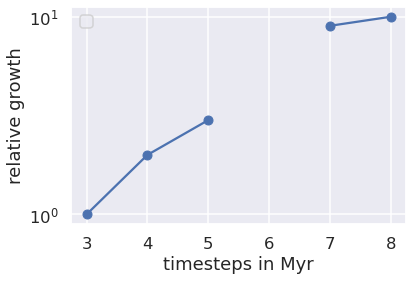

In [26]:
plt.semilogy(b, a, marker='o')
plt.xlabel('timesteps in Myr')
plt.ylabel('relative growth')
plt.legend()

## Start plotting entire ts here

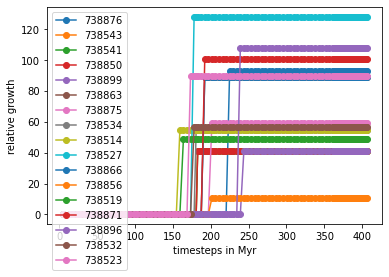

In [22]:
for key in ts_accreted_m.keys():
    plt.plot(timesteps, ts_accreted_m[key], label=key, marker='o')
plt.xlabel('timesteps in Myr')
plt.ylabel('relative growth')
plt.legend()

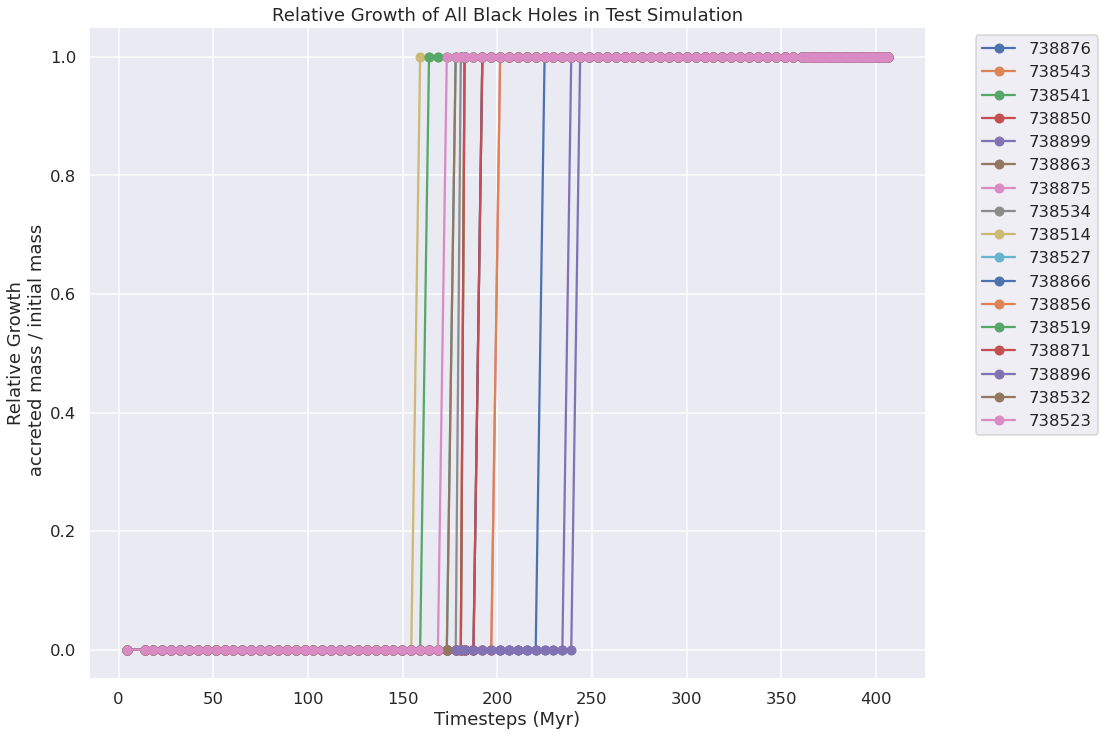

In [83]:
fig, ax = plt.subplots(figsize=(15, 12))
for bh_id in ts_accreted_m.keys():
    plt.plot(timesteps, rel_growth[bh_id], '-o', label=bh_id)
ax.set(title='Relative Growth of All Black Holes in Test Simulation', xlabel='Timesteps (Myr)', ylabel=u'Relative Growth\n accreted mass / initial mass')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig('allBH_relgrowth_with0.png', dpi=500, bbox_inches='tight')

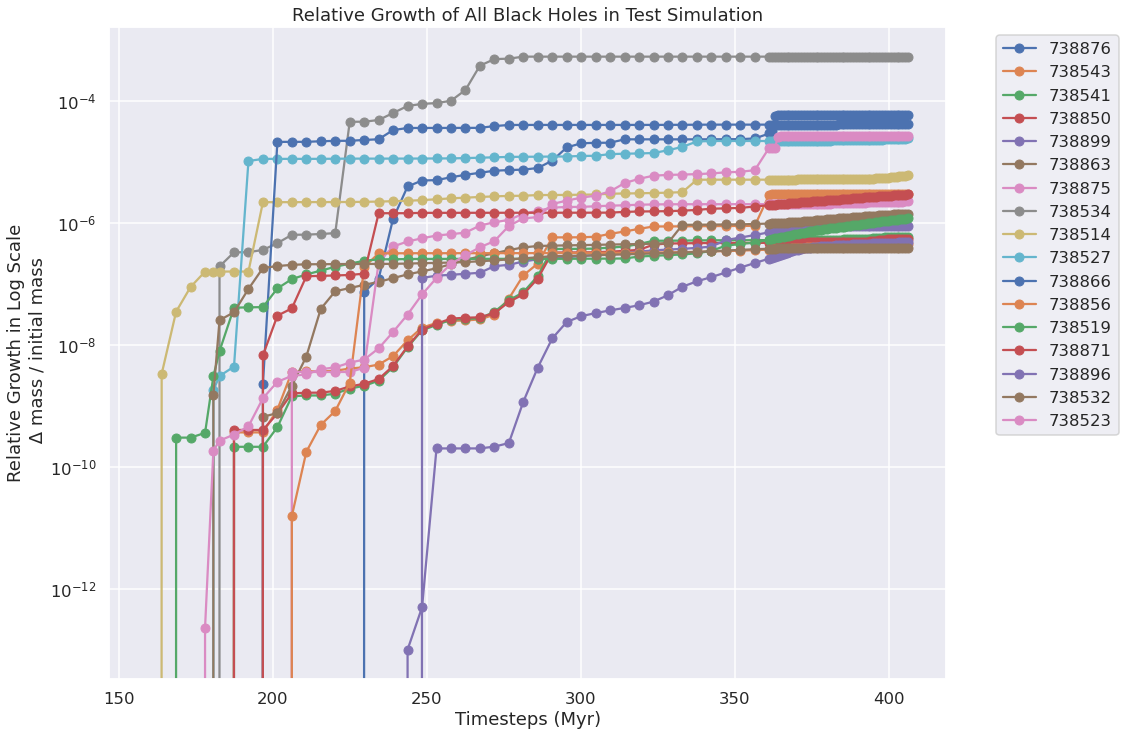

In [27]:
fig, ax = plt.subplots(figsize=(15, 12))
for bh_id in ts_accreted_m.keys():
    plt.semilogy(timesteps, rel_growth_non0[bh_id]-1, '-o', label=bh_id)
ax.set(title='Relative Growth of All Black Holes in Test Simulation', xlabel='Timesteps (Myr)', ylabel=u'Relative Growth in Log Scale\n \u0394 mass / initial mass')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('allBH_relgrowth_non0_log.png', dpi=500, bbox_inches='tight')

## Plot the relative growth of the BH that grows the most

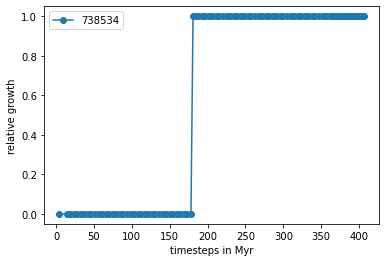

In [89]:
plt.plot(timesteps, rel_growth[most_grown_bh_id], label=most_grown_bh_id, marker='o')
plt.xlabel('timesteps in Myr')
plt.ylabel('relative growth')
plt.legend()

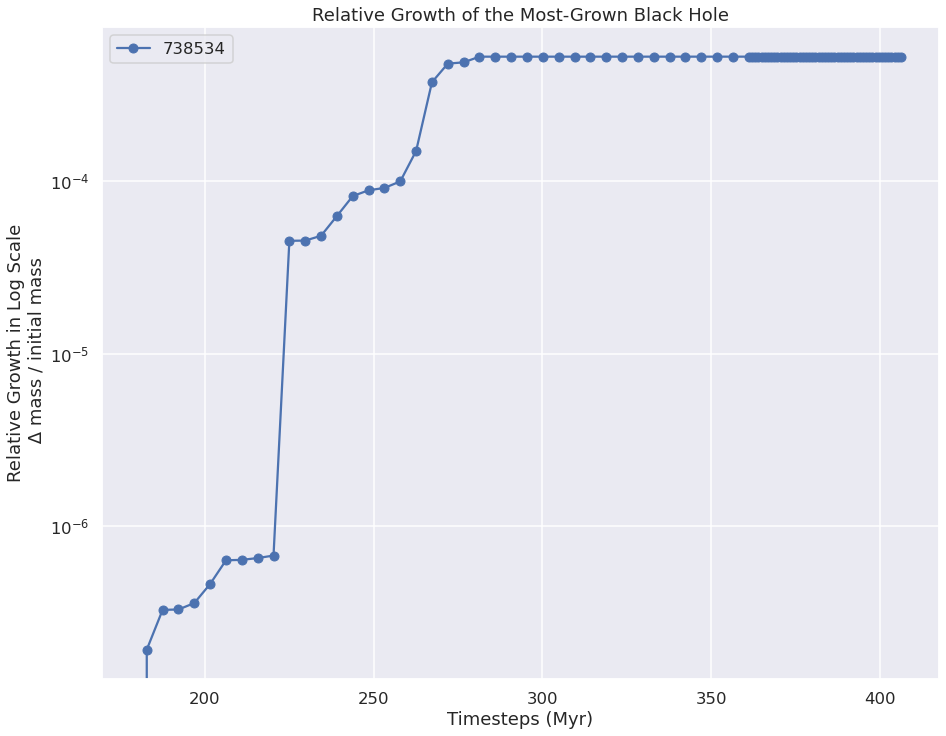

In [35]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.semilogy(timesteps, rel_growth_non0[most_grown_bh_id]-1, 'b-o', label=most_grown_bh_id)
ax.set(title='Relative Growth of the Most-Grown Black Hole', xlabel='Timesteps (Myr)', ylabel=u'Relative Growth in Log Scale\n \u0394 mass / initial mass')
ax.legend()
plt.savefig('mostgrownthBH.png', dpi=500, bbox_inches='tight')